In [1]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
## Important:
# If the rapidly fluctuating region in the potential is not at the appropriate resolution
# there will be high frequency noise in the power spectrum visible in the last plot

In [4]:
nLat = 512; print(nLat)
hLat = nLat//2
knyq = int(hLat+1)
kcut = knyq//2

lenLat = 1000.
dx = lenLat/nLat
dk = 2.*np.pi/lenLat

xlist = np.arange(1, nLat+1)
klist = xlist - hLat

m2test = 1.
lamb = 0.05
phi0 = 1.
fraction = 2.

nTime = nLat
nSims = nLat//2
nCols = 2
alpha = 8
dt = dx/alpha
dtout = dt*alpha

512


In [5]:
sim_location = lambda sim: '/gpfs/dpirvu/dilatonBH/single_mode_sim'+str(sim)+'_fields.dat'
plot_location = '/home/dpirvu/project/dilaton_bh/plots/'
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

def extract_sim(nT, nL, sim):
    data = np.genfromtxt(sim_location(sim))
    simulation = [np.reshape(data[:,col], (nT, nL)) for col in range(nCols)]
    return np.asarray(simulation)

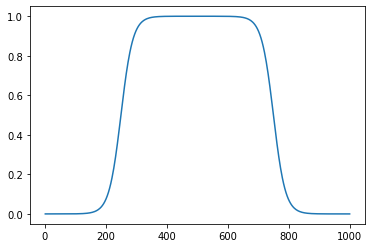

(257, 512)


In [6]:
# Now on to the potential term
w2free = lambda k, m2: np.sqrt((k*dk)**2. + m2)
w2bare = np.genfromtxt('../data/frequencies'+'_N'+str(nLat)+'_L'+str(int(lenLat))+'_lambda'+str('%.3f'%lamb)+'.txt')[1:]
def confOmega(x, lamb, fraction):
    if x>0.:
        return 1./(1.+np.exp(2.*lamb*(x - nLat/fraction/2.)))
    else:
        return 1./(1.+np.exp(-2.*lamb*(x + nLat/fraction/2.)))

Ux = lambda xL, m2, lamb, fraction: np.asarray([m2*confOmega(x, lamb, fraction) for x in xL])
Uk = lambda k, m2, lamb, fraction: np.size(xlist)**-1. * np.sum(Ux(xlist, m2, lamb, fraction)*np.exp(-1j*xlist*k*dx*dk))
if True:
    plt.plot(xlist*dx, Ux(xlist-hLat, m2test, lamb, fraction))
    plt.show()

# Below is the field power spectrum and expected mass correction
#mat = np.loadtxt('../data/transfMatrix'+'_N'+str(nLat)+'_L'+str(int(lenLat))+'.txt', skiprows=2)
#transfMatrix = np.reshape(mat[:,0]+1j*mat[:,1],(knyq,nLat))
mat = np.genfromtxt('../data/transfMatrix'+'_N'+str(nLat)+'_L'+str(int(lenLat))+'_lambda'+str('%.3f'%lamb)+'.txt')
transfMatrix = np.reshape(mat[2:],(int(mat[0]),int(mat[1]))); print(np.shape(transfMatrix))
if False:
    for n in range(knyq):
        plt.plot(xlist*dx, transfMatrix[n])
        plt.plot(xlist*dx, np.dot(np.transpose(transfMatrix), np.asarray([0. if x!=n else 1. for x in range(knyq)])), ls=':')
        #plt.xlim(xlist[0]*dx, 0.)
        plt.show()

norm = 1./ phi0 / np.sqrt(4. * lenLat)
eigenbasis = norm / w2bare**0.25
free_eigenbasis = np.asarray([norm / w2free(k, m2test)**0.25 if k !=0 else 0 for k in klist])
free_field_fluctuations = np.asarray([np.sum(free_eigenbasis*np.exp(-1j*x*klist*dx*dk)) for x in xlist])

spectral_field = np.dot(np.transpose(transfMatrix), eigenbasis)[:knyq-1]
spectral_field[0] = 0.
field_fluctuations = np.asarray([np.sum(2.*spectral_field*np.exp(-1j*x*klist[klist<=0]*dx*dk)) for x in xlist])

if False:
    plt.plot(xlist*dx, free_field_fluctuations)
    plt.plot(xlist*dx, field_fluctuations)
    plt.show()

pspec = np.abs(spectral_field)**2
fluct_variance = np.sum(pspec)

th_masses = lambda m2, lamb: m2 + 0.5 * lamb * fluct_variance
omega2_fit = lambda k, m2: k**2. + m2

In [7]:
all_data = np.asarray([extract_sim(nTime, nLat, sim) for sim in range(nSims)])
print('Done')
print(np.shape(all_data))

Done
(256, 2, 512, 512)


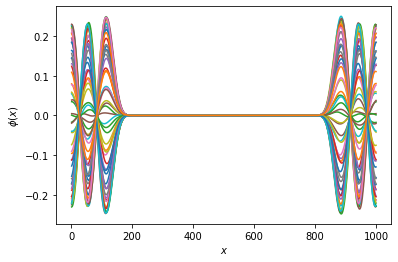

In [8]:
for time in range(0, nTime, 10):
    plt.plot(xlist*dx, all_data[2][0][time])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\phi(x)$')

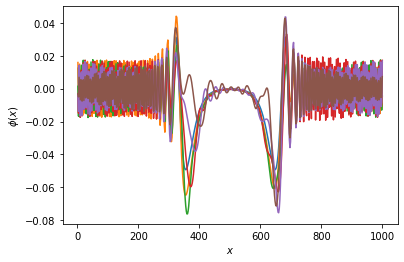

In [9]:
for time in range(0, nTime, 100):
    plt.plot(xlist*dx, all_data[87][0][time])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\phi(x)$')

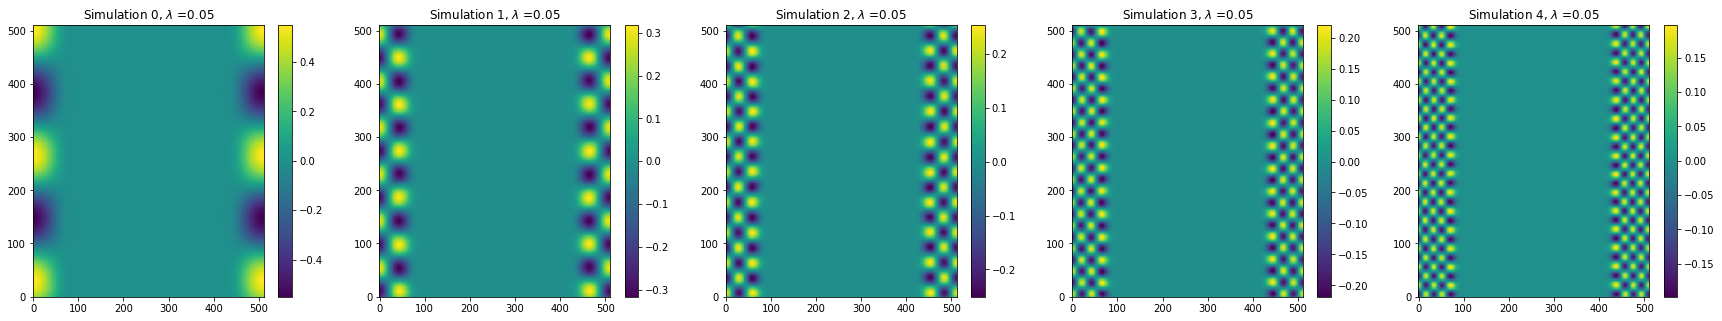

In [10]:
list_lambda = [lamb]
for lll, lamb in enumerate(list_lambda):
#    list_sims = random.sample(range(nSims), 5)
    list_sims = np.arange(0, 5, 1)

    fig, ax = plt.subplots(figsize = (6*len(list_sims), 5), ncols=len(list_sims))
    for s, sim in enumerate(list_sims):
        im0 = ax[s].imshow(all_data[sim][0], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[s])
        ax[s].set_title('Simulation '+str(sim)+r', $\lambda$ ='+str(lamb))
    plt.show()

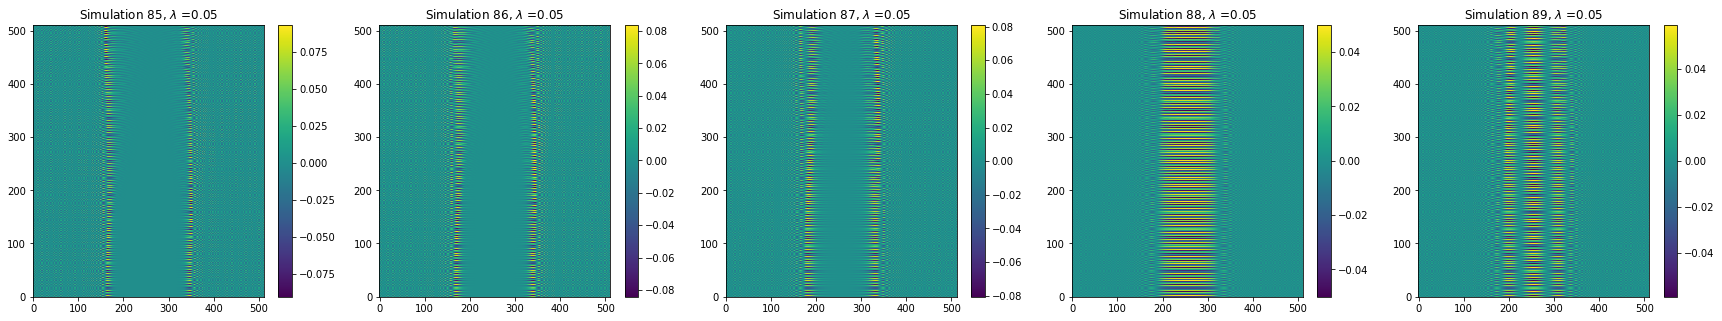

In [11]:
list_lambda = [lamb]
for lll, lamb in enumerate(list_lambda):
#    list_sims = random.sample(range(nSims), 5)
    list_sims = np.arange(85, 90, 1)

    fig, ax = plt.subplots(figsize = (6*len(list_sims), 5), ncols=len(list_sims))
    for s, sim in enumerate(list_sims):
        im0 = ax[s].imshow(all_data[sim][0], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[s])
        ax[s].set_title('Simulation '+str(sim)+r', $\lambda$ ='+str(lamb))
    plt.show()

In [12]:
intervals = np.asarray([2.*np.pi/dt/np.sqrt(i) for i in w2bare])
list_intervals = lambda i: np.asarray([y for y in [int(np.round(x*8.*np.pi/(dtout*np.sqrt(w2bare[i])))) for x in range(1, nTime, 1)] if y < nTime])

[0.00029766316825082504, 0.0003648117138961824, 0.0002909369424359191, -4.283510895765338e-05, -0.0001950288948283666, -0.00040428834652311705, -0.0002069634325219417, -8.013578999995932e-05, 0.0003962293926809185, 0.00037424563165746347, 0.00012563627694648784, -2.40426063563759e-05, -8.829321500069133e-05, -0.0005539723644016046, -0.00015078346584871394, 0.0002522720492816146, 6.441709349026462e-05, 0.0003798822444295844]
[]


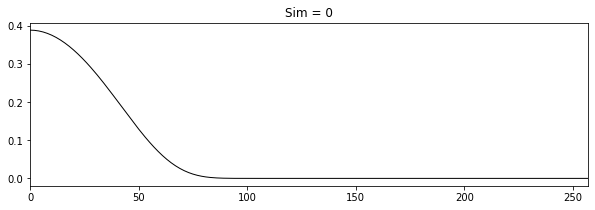

[ 40  79 119 158 198 237 277 316 356 396 435 475]


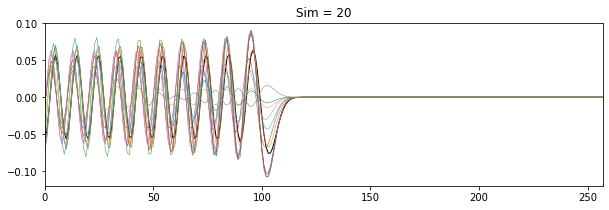

[ 23  45  68  90 113 135 158 180 203 225 248 270 293 315 338 360 383 405
 428 450 473 495]


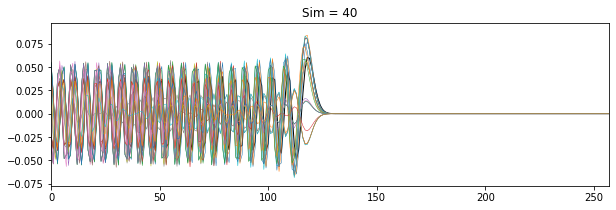

[ 16  33  49  65  82  98 114 131 147 163 180 196 212 229 245 261 277 294
 310 326 343 359 375 392 408 424 441 457 473 490 506]


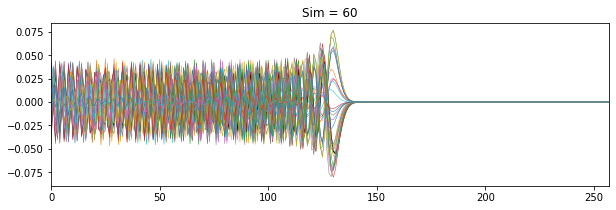

[ 13  27  40  53  67  80  93 107 120 134 147 160 174 187 200 214 227 240
 254 267 280 294 307 320 334 347 360 374 387 401 414 427 441 454 467 481
 494 507]


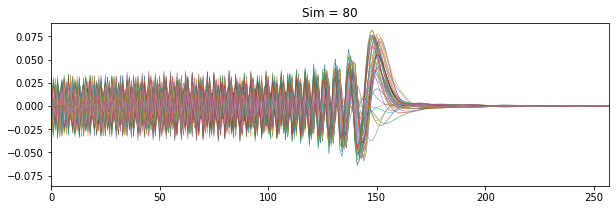

[ 13  25  38  51  63  76  88 101 114 126 139 152 164 177 190 202 215 228
 240 253 265 278 291 303 316 329 341 354 367 379 392 405 417 430 442 455
 468 480 493 506]


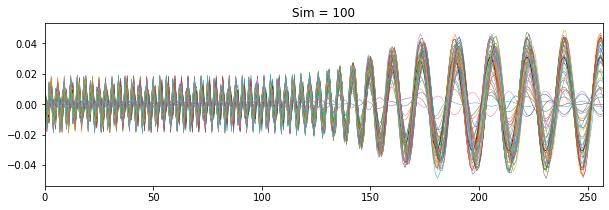

[ 12  24  36  48  60  72  84  95 107 119 131 143 155 167 179 191 203 215
 227 239 251 262 274 286 298 310 322 334 346 358 370 382 394 406 418 429
 441 453 465 477 489 501]


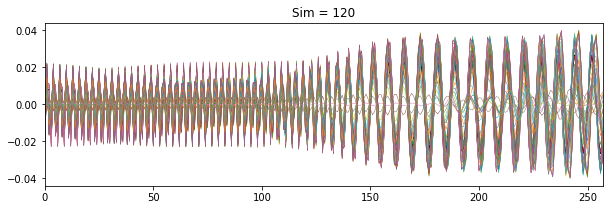

[ 11  22  33  44  56  67  78  89 100 111 122 133 144 155 167 178 189 200
 211 222 233 244 255 267 278 289 300 311 322 333 344 355 366 378 389 400
 411 422 433 444 455 466 477 489 500 511]


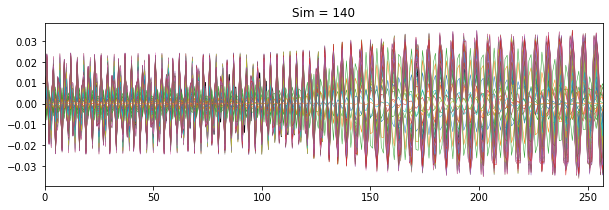

[ 10  21  31  41  51  62  72  82  93 103 113 124 134 144 154 165 175 185
 196 206 216 226 237 247 257 268 278 288 298 309 319 329 340 350 360 371
 381 391 401 412 422 432 443 453 463 473 484 494 504]


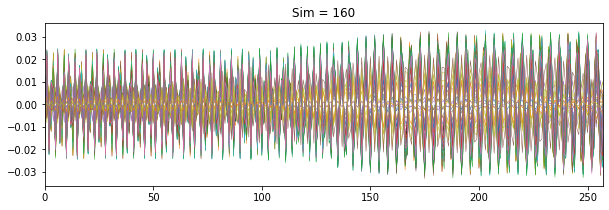

[ 10  19  29  38  48  57  67  76  86  95 105 114 124 134 143 153 162 172
 181 191 200 210 219 229 238 248 257 267 277 286 296 305 315 324 334 343
 353 362 372 381 391 401 410 420 429 439 448 458 467 477 486 496 505]


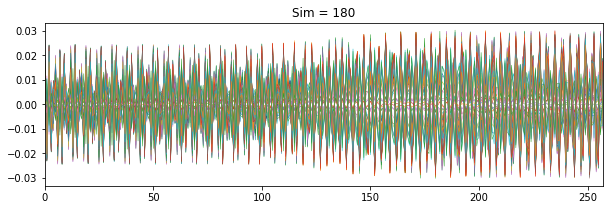

[  9  18  27  35  44  53  62  71  80  89  97 106 115 124 133 142 151 159
 168 177 186 195 204 212 221 230 239 248 257 266 274 283 292 301 310 319
 328 336 345 354 363 372 381 390 398 407 416 425 434 443 452 460 469 478
 487 496 505]


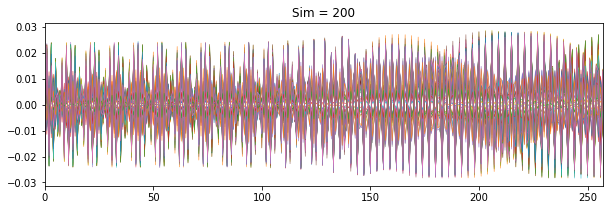

[  8  16  25  33  41  49  58  66  74  82  91  99 107 115 124 132 140 148
 157 165 173 181 190 198 206 214 222 231 239 247 255 264 272 280 288 297
 305 313 321 330 338 346 354 363 371 379 387 396 404 412 420 429 437 445
 453 461 470 478 486 494 503 511]


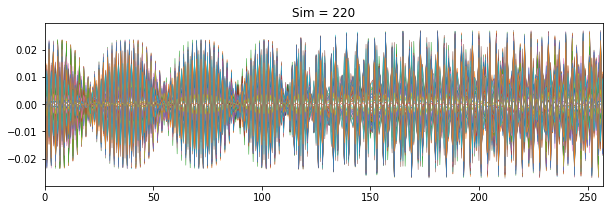

[  8  15  23  30  38  45  53  60  68  75  83  90  98 105 113 120 128 135
 143 151 158 166 173 181 188 196 203 211 218 226 233 241 248 256 263 271
 278 286 294 301 309 316 324 331 339 346 354 361 369 376 384 391 399 406
 414 421 429 437 444 452 459 467 474 482 489 497 504]


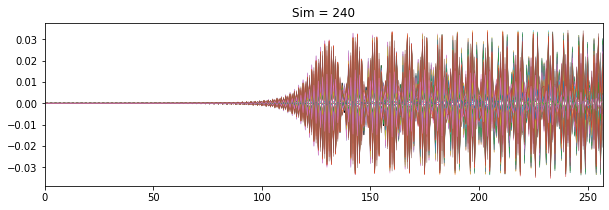

In [13]:
if True:
    print([np.mean(all_data[:, 0, time]) for time in range(0,nTime,30)])

    for sim in range(0, nSims, 20):
#        fig, ax = plt.subplots(2, 1, figsize = (20, 5))
        fig, ax = plt.subplots(figsize = (10, 3), nrows=1)
        ax.plot(all_data[sim, 0, 0], linewidth=1, color='k')
        print(list_intervals(sim))
        [ax.plot(all_data[sim, 0, time], linewidth=0.5) for time in list_intervals(sim)]
#        [ax[1].plot(all_data[sim, 1, time]) for time in range(0,nTime,30)]
        plt.title('Sim = '+str(sim))
        plt.xlim(0, knyq)
        plt.show()

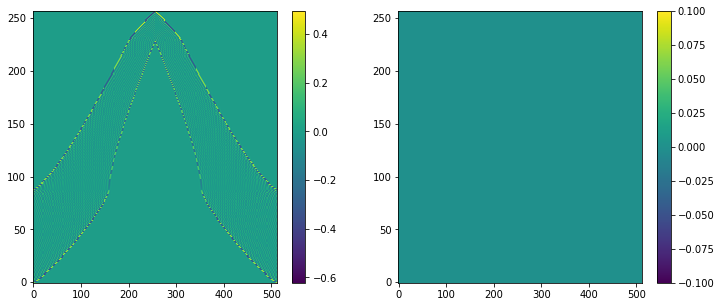

In [14]:
fig, ax = plt.subplots(figsize = (12, 5), ncols=2)
im0 = ax[0].imshow(np.real(transfMatrix), aspect='auto', interpolation='none', origin='lower')
clb = plt.colorbar(im0, ax = ax[0])
im1 = ax[1].imshow(np.imag(transfMatrix), aspect='auto', interpolation='none', origin='lower')
clb = plt.colorbar(im1, ax = ax[1])

In [15]:
%run '/home/dpirvu/project/BH_triggered_VD/data/findSpectrum.py'

In [16]:
spectrum = Spectrum(nLat, lenLat, lamb, fraction)

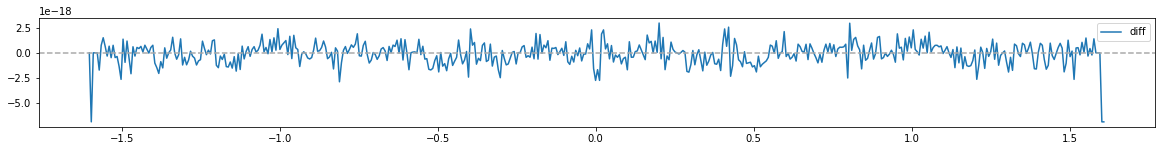

In [17]:
for sim in range(0, 1):
    fig, ax = plt.subplots(1, 1, figsize = (20,2))
    colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))

    unit_vec = np.asarray([0. if x!=sim else norm/w2bare[sim]**0.25 for x in range(knyq)])
    projection = np.dot(np.transpose(transfMatrix),unit_vec)

    time = 0
    dataPS = np.abs(np.fft.ifft(all_data[sim,0,time]))
    
    sensitivity, EnV, phinV, phikV = spectrum.getNonDegenerateSpectrum()
    pyth = np.abs(np.roll(phikV[sim],nLat//2))

    plt.plot(klist*dk, np.abs(projection) - dataPS, label='diff', alpha=1)
#    plt.plot(klist*dk, np.sqrt(nLat)*pyth * norm/w2bare[sim]**0.25 - dataPS, label='diff th', alpha=1)
#    plt.plot(klist*dk, np.sqrt(nLat)*pyth * norm/w2bare[sim]**0.25 - np.abs(projection), label='diff th th', alpha=1)

#    plt.xlim(-knyq*dk, 0)
#    plt.ylim(-1e-17, 1e-17)
    plt.legend(loc='upper right')
    plt.axhline(0, ls='--', color='darkgray')
    plt.show()

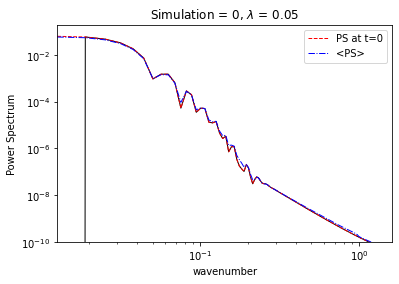

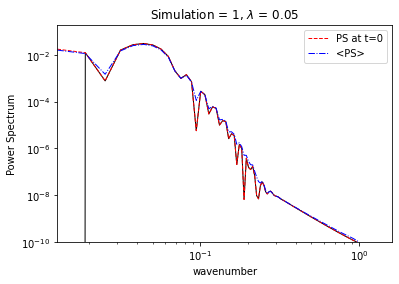

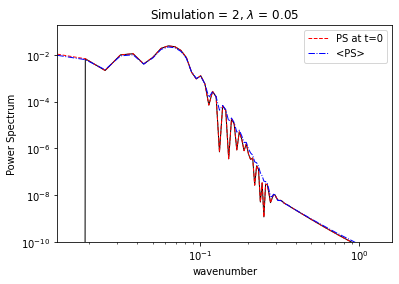

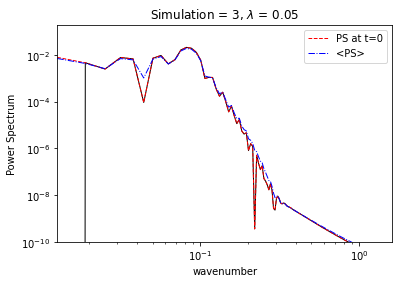

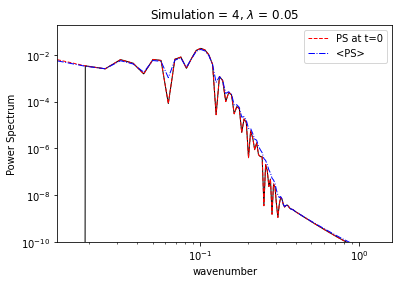

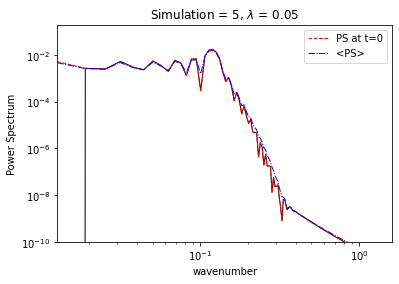

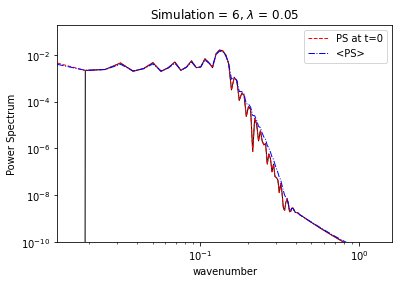

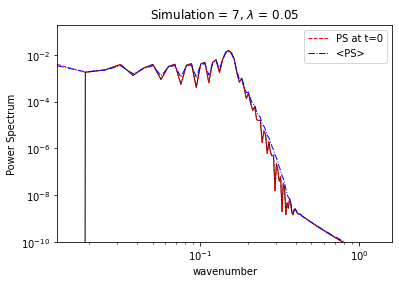

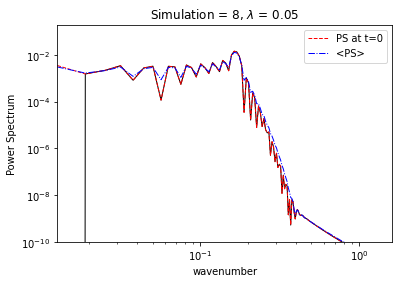

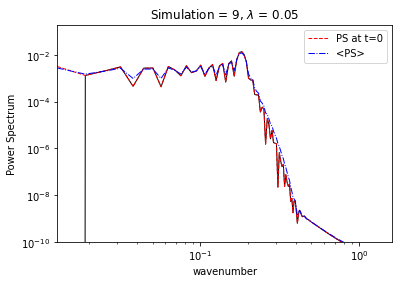

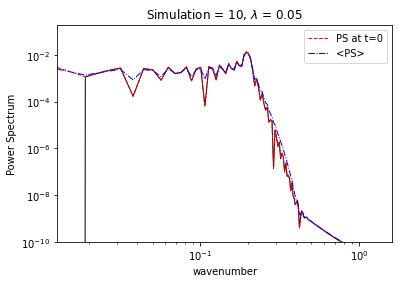

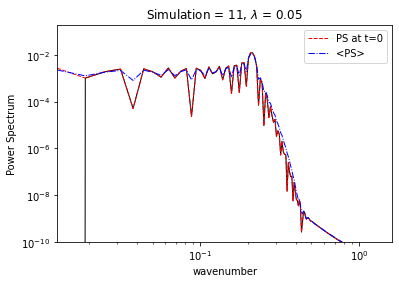

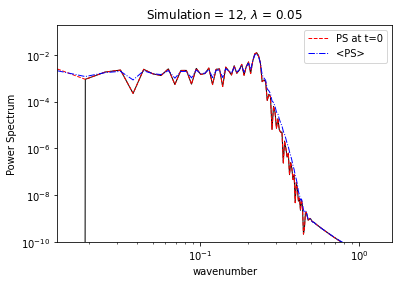

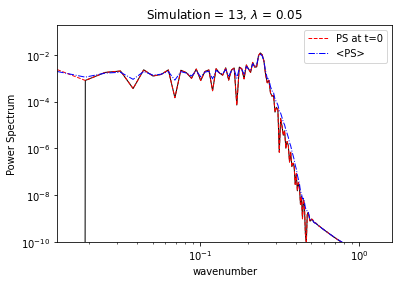

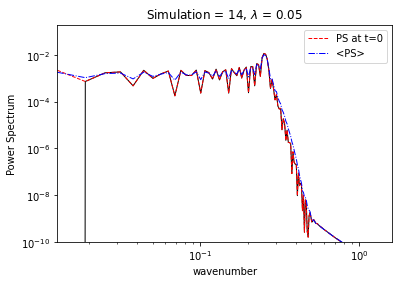

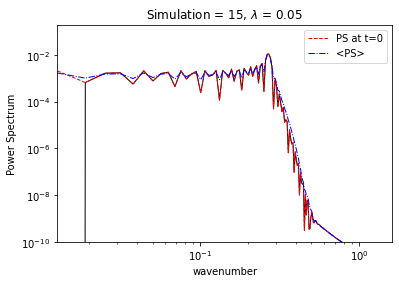

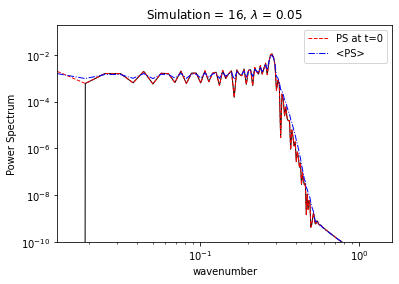

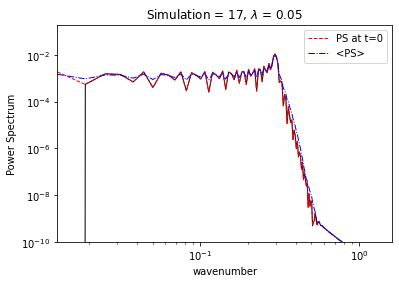

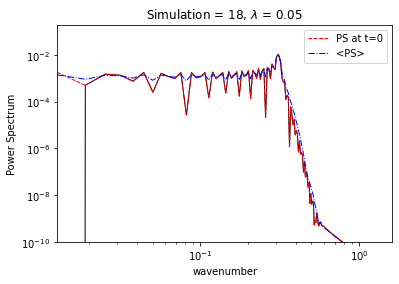

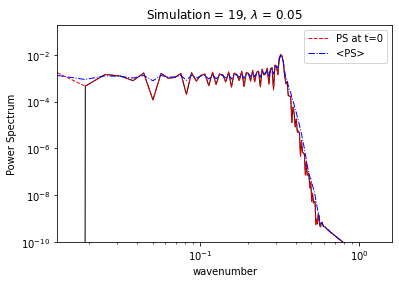

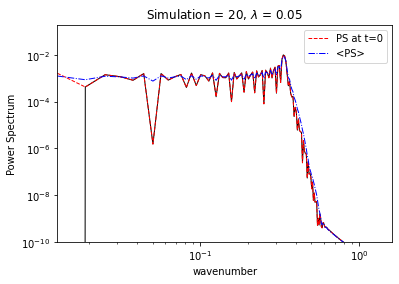

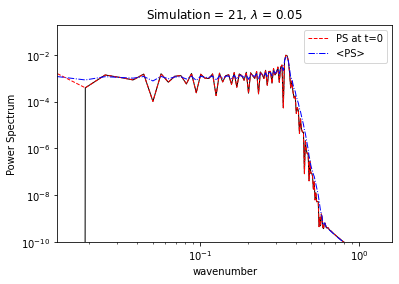

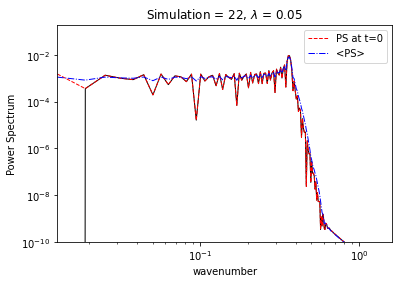

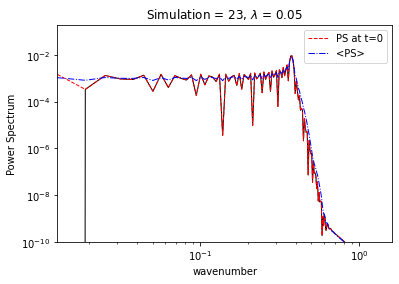

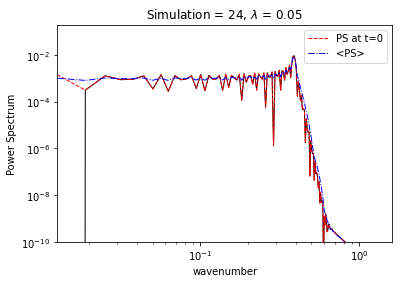

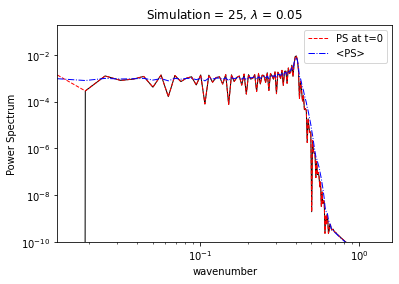

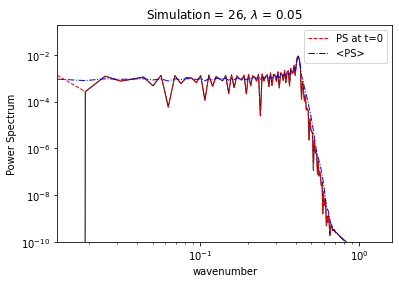

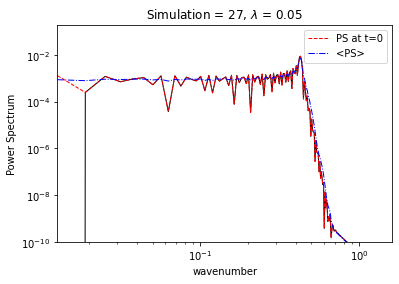

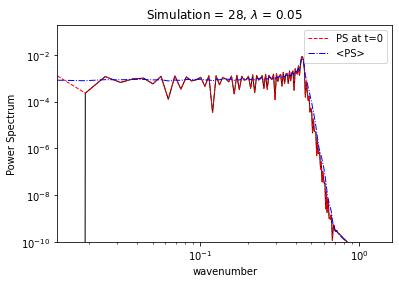

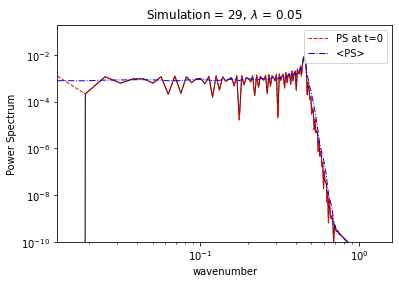

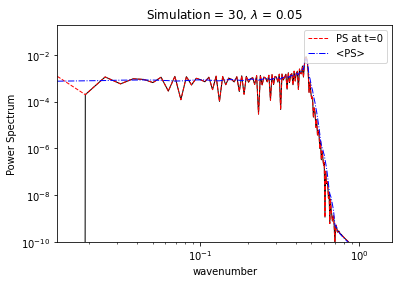

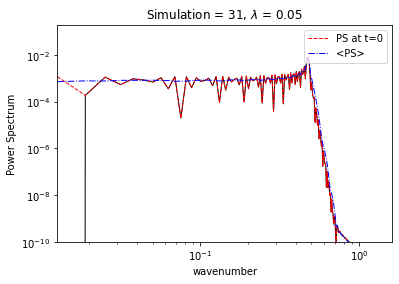

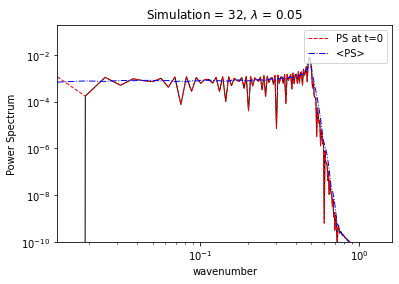

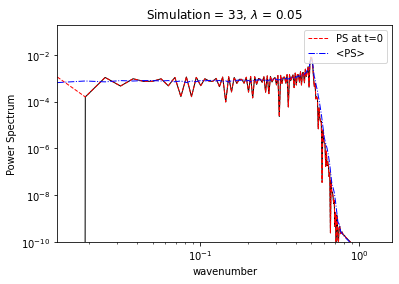

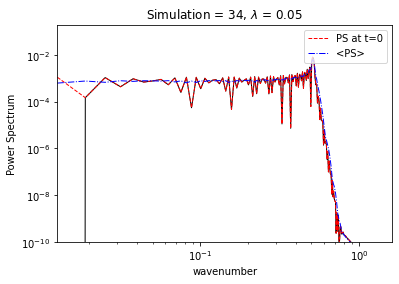

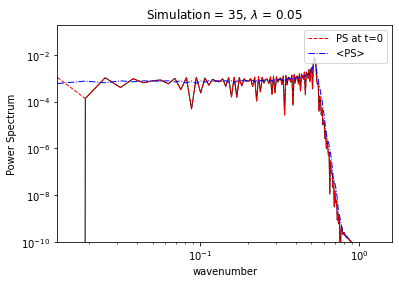

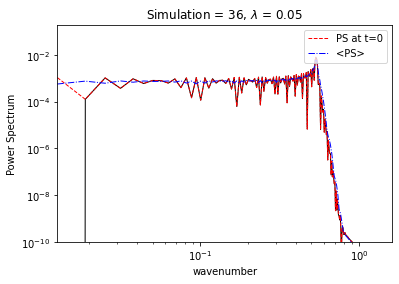

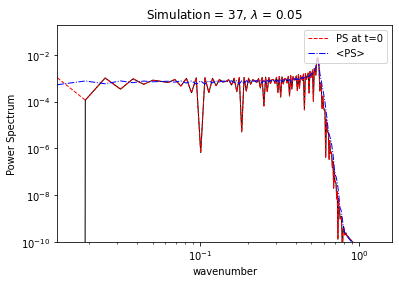

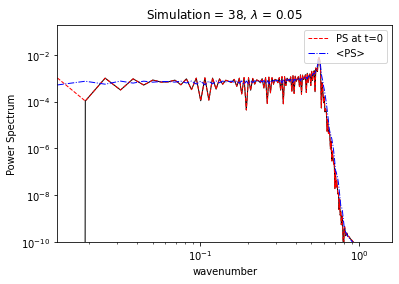

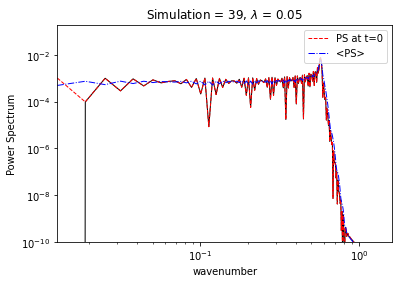

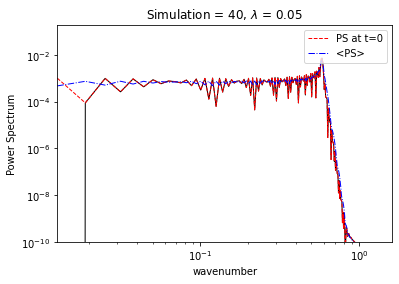

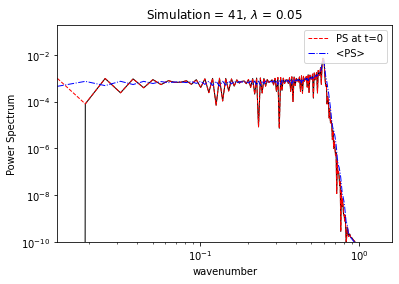

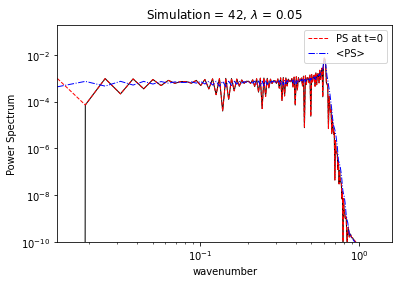

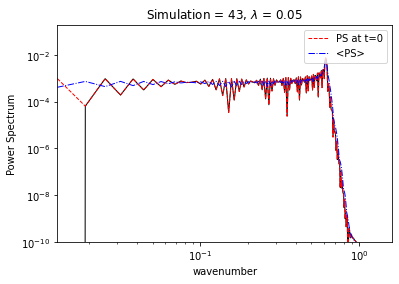

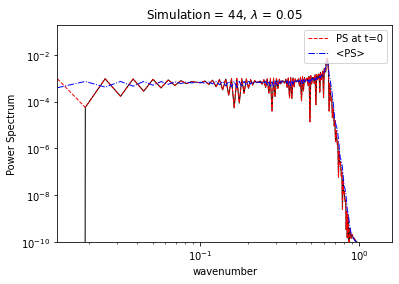

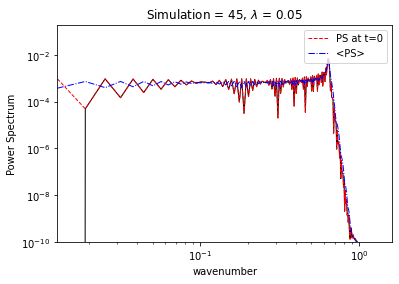

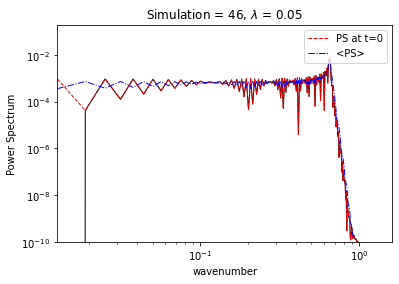

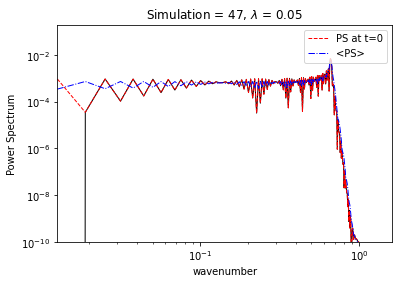

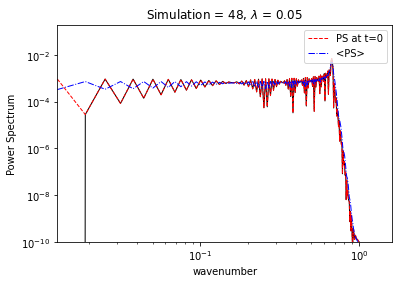

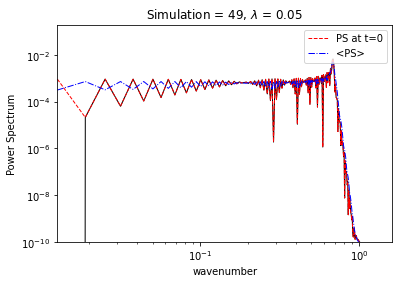

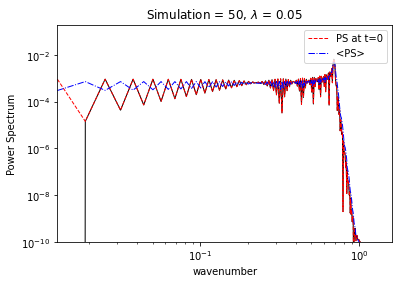

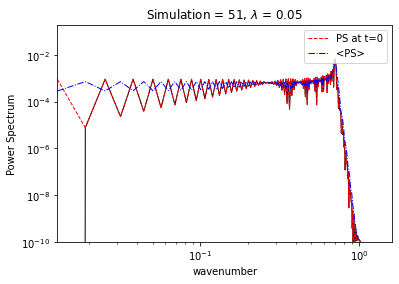

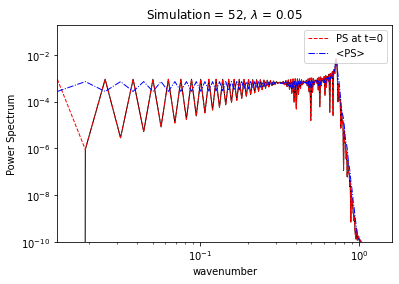

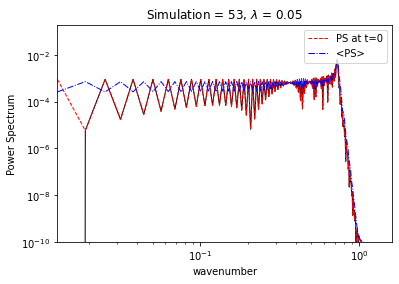

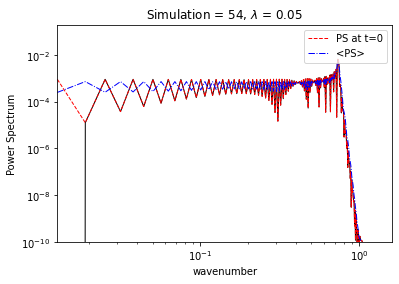

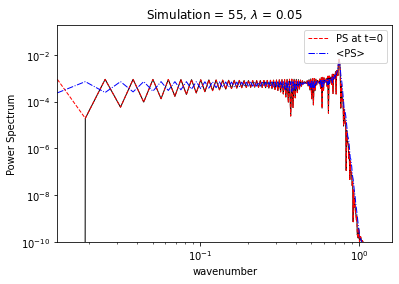

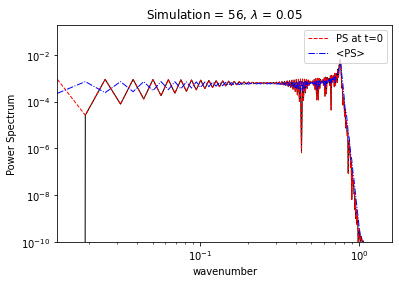

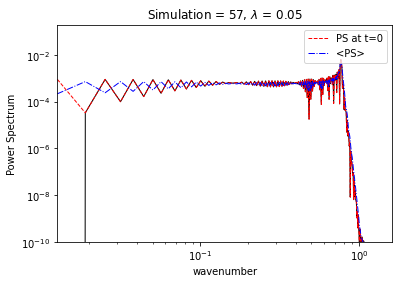

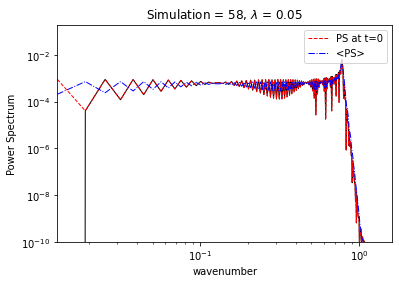

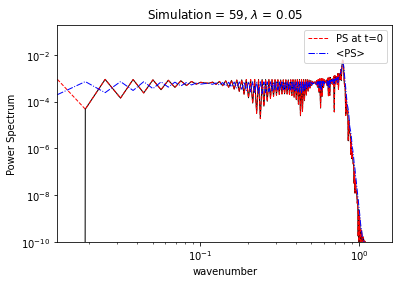

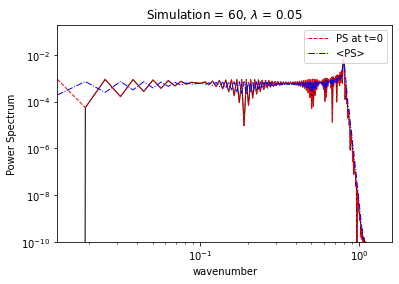

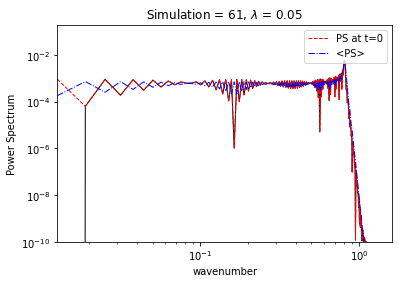

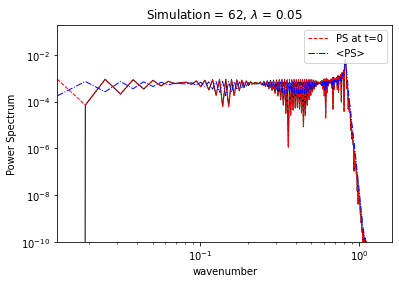

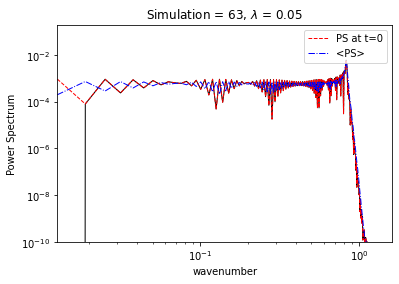

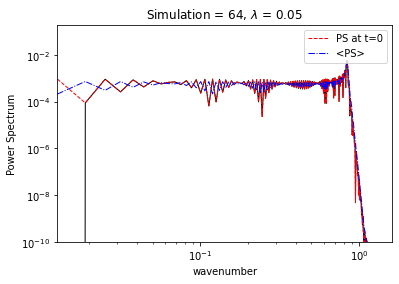

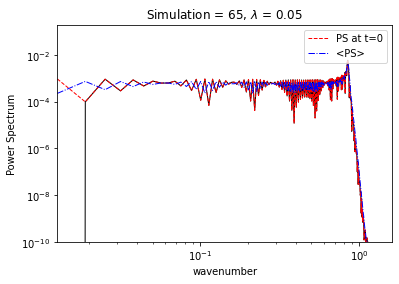

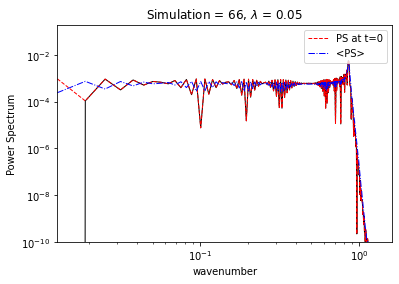

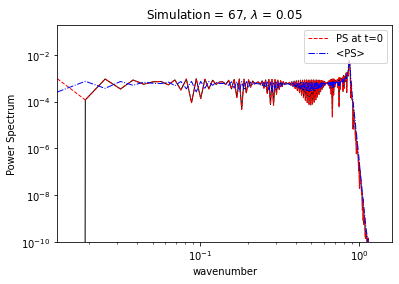

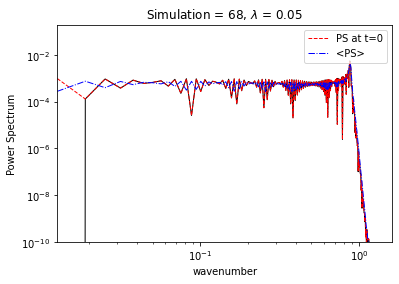

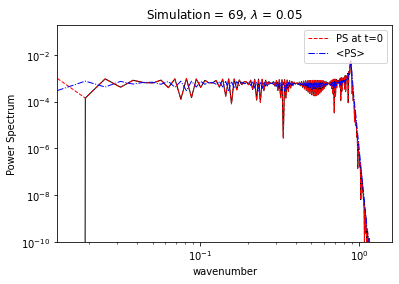

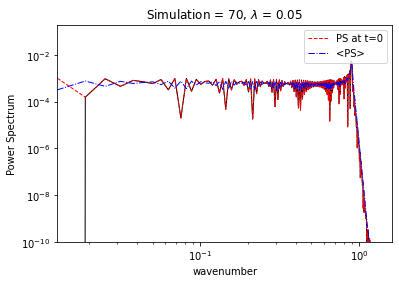

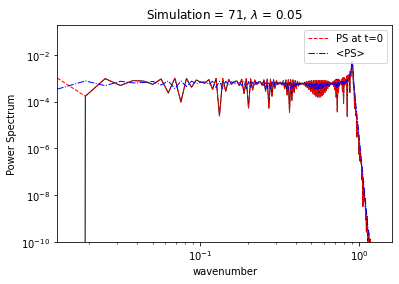

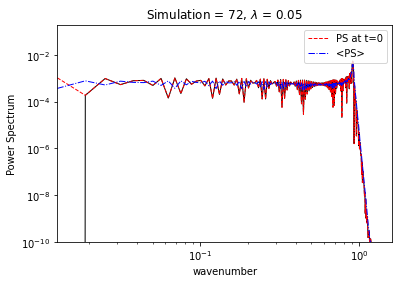

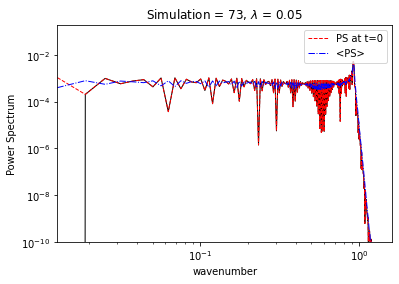

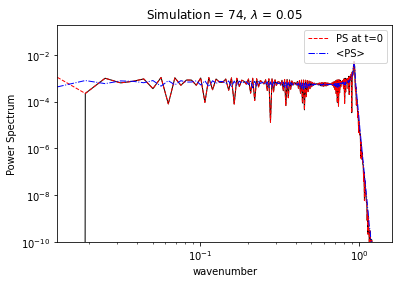

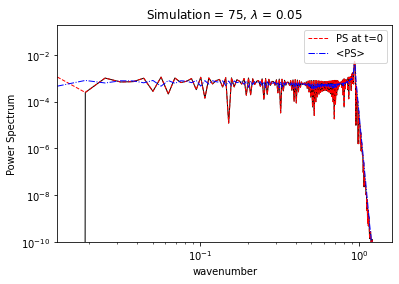

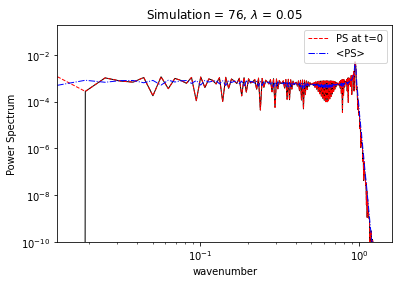

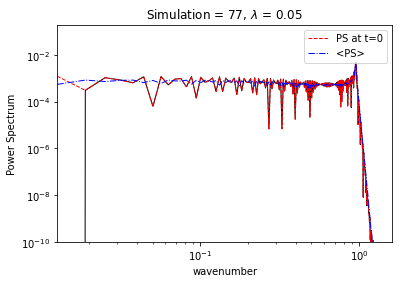

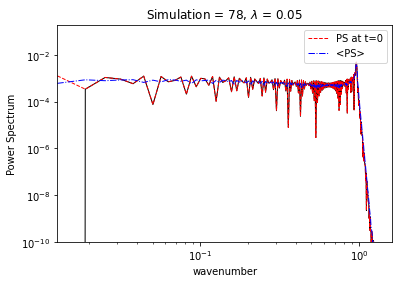

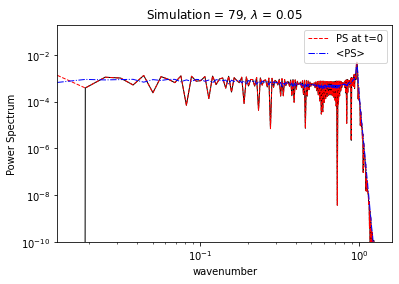

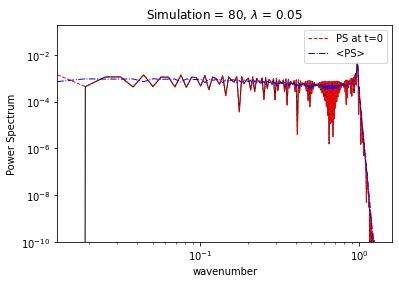

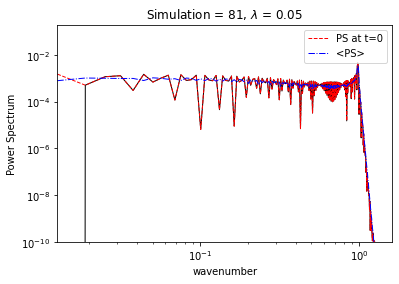

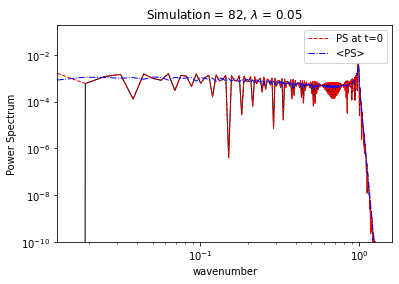

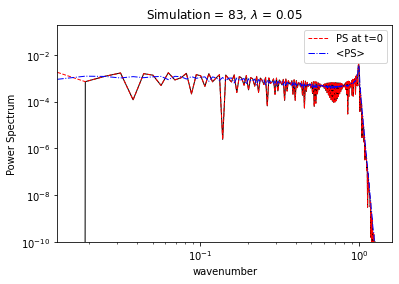

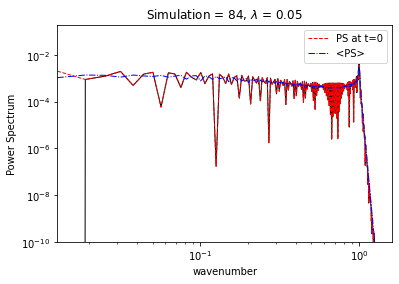

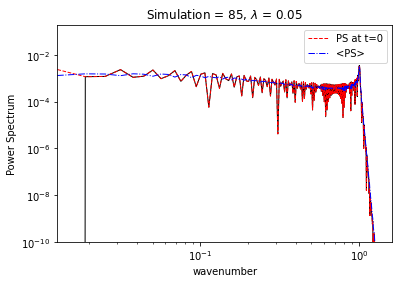

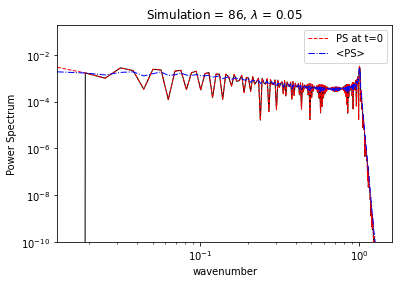

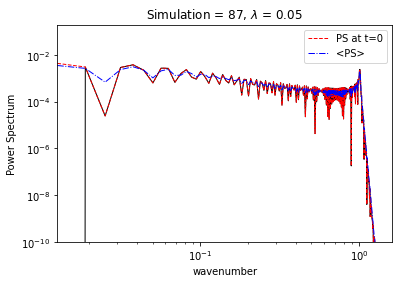

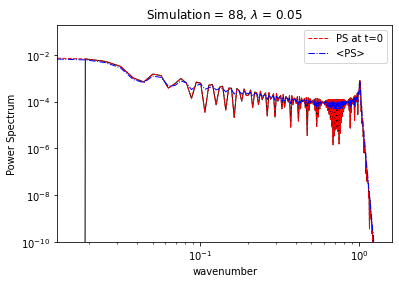

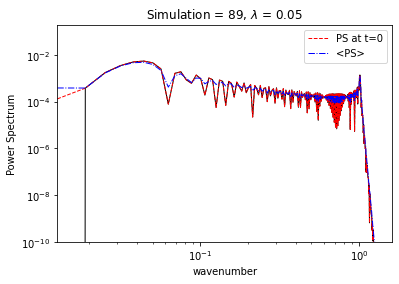

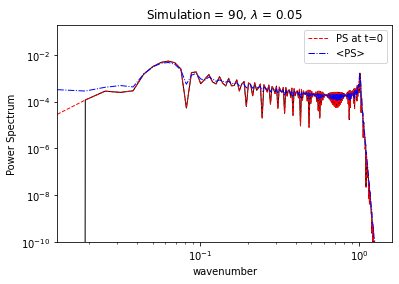

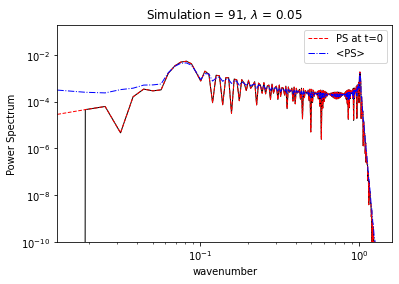

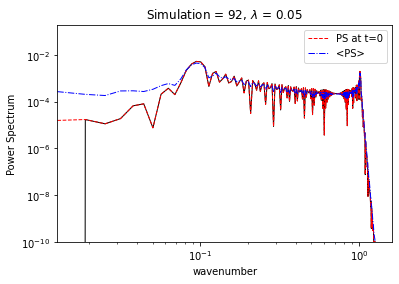

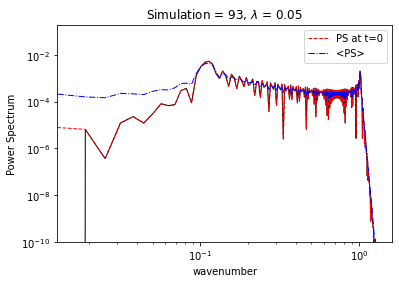

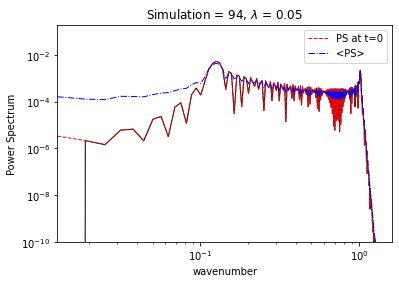

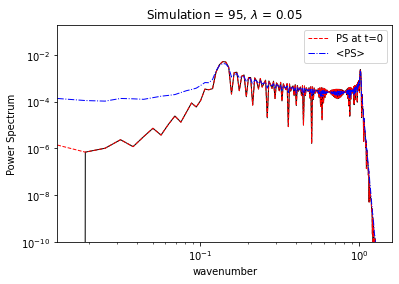

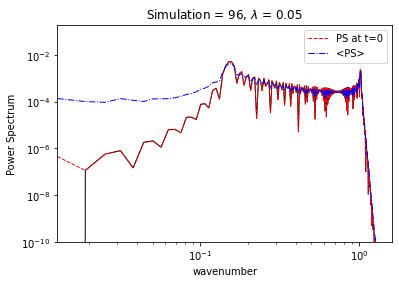

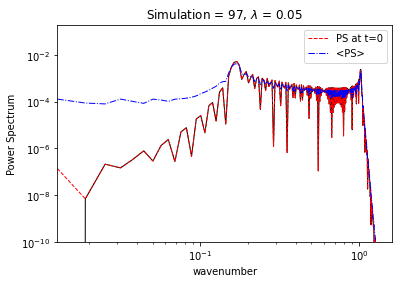

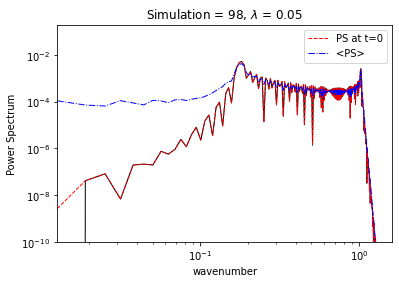

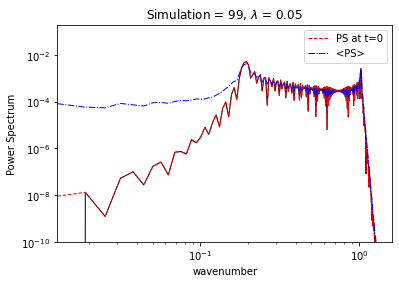

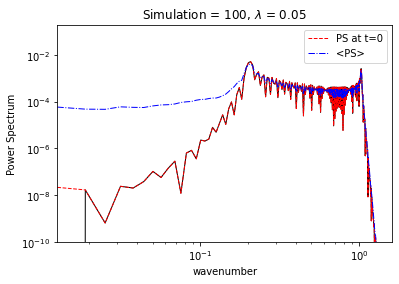

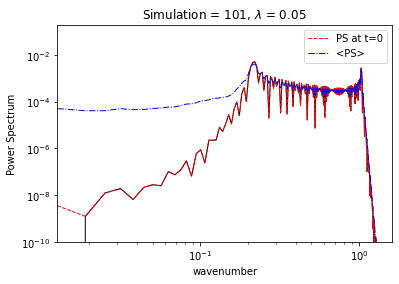

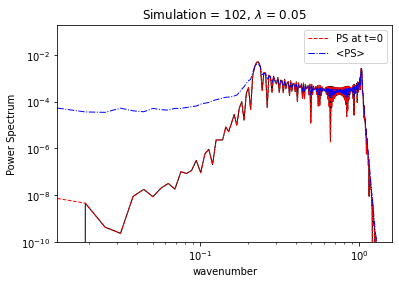

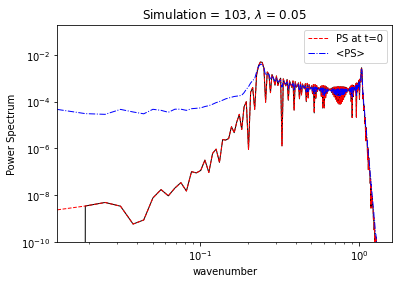

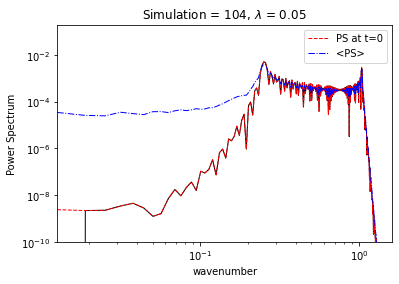

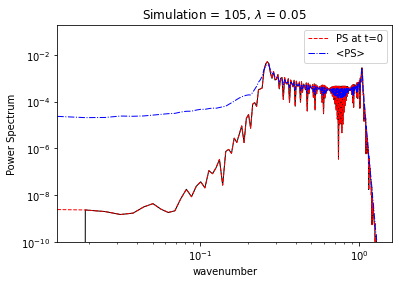

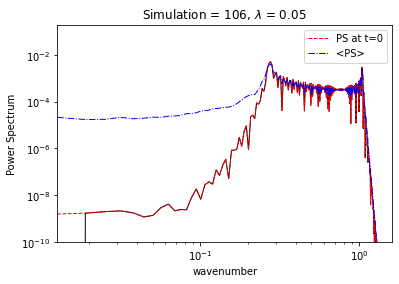

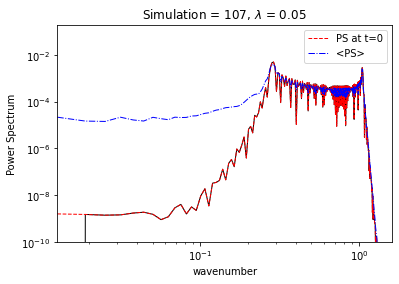

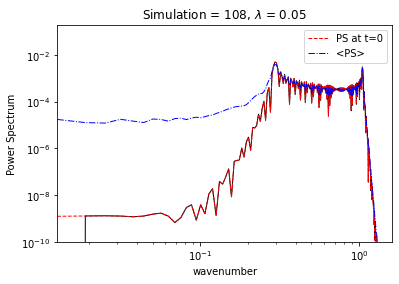

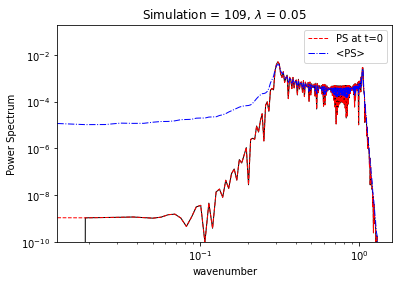

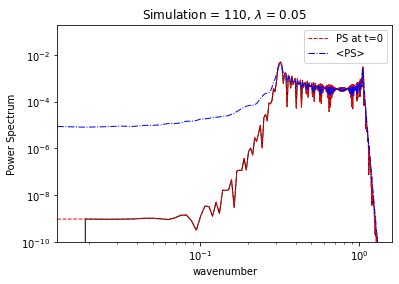

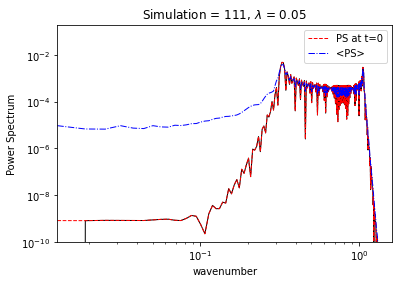

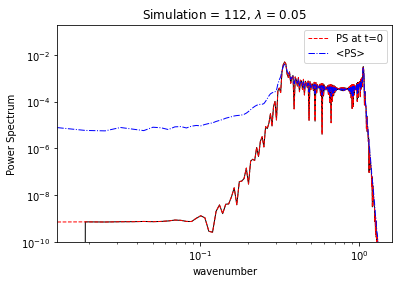

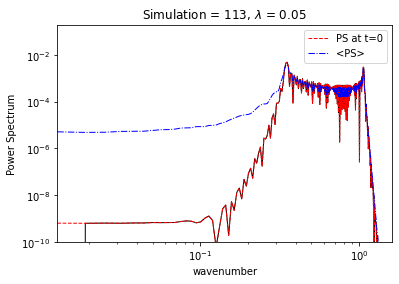

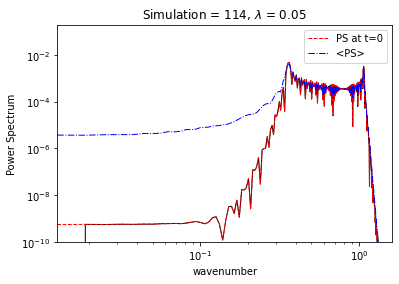

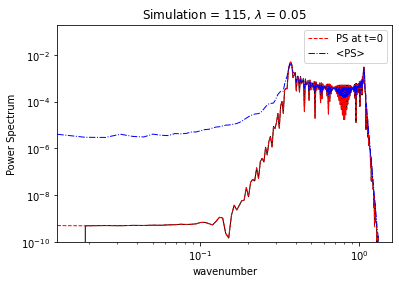

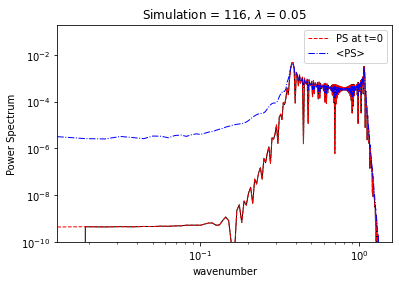

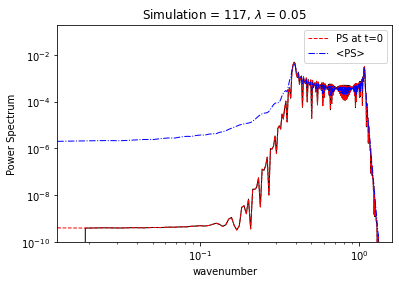

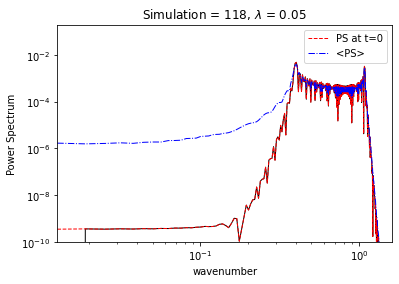

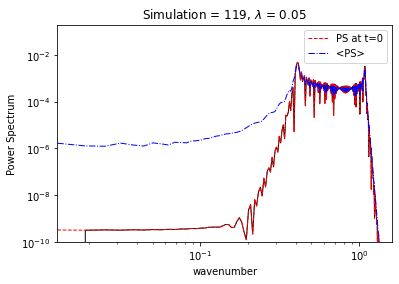

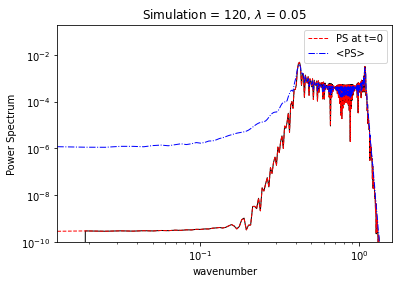

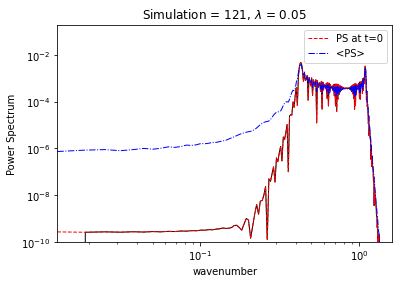

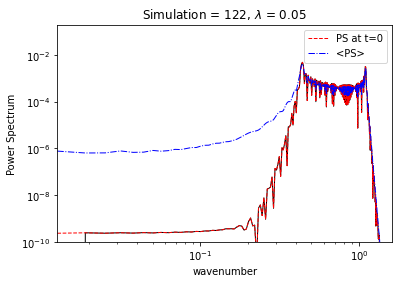

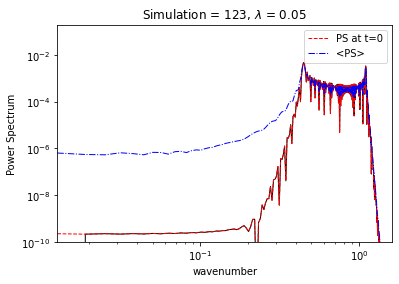

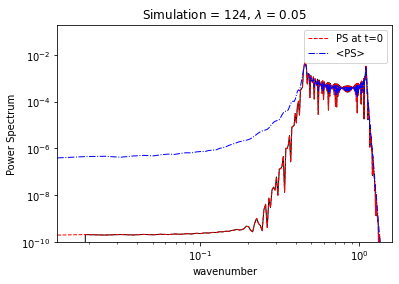

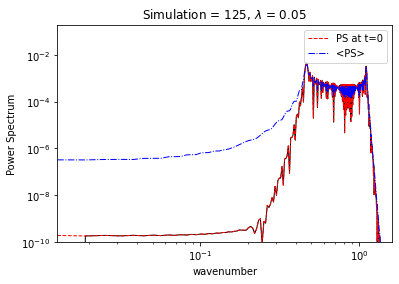

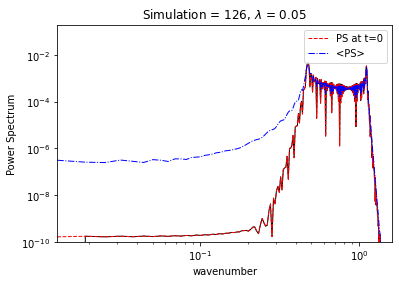

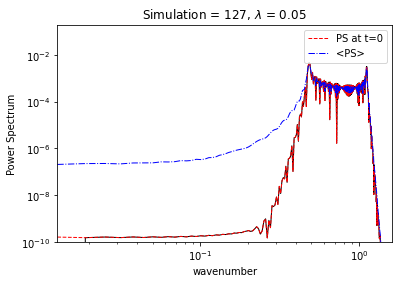

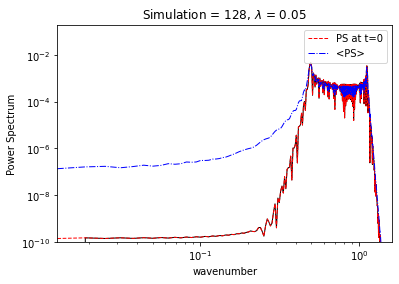

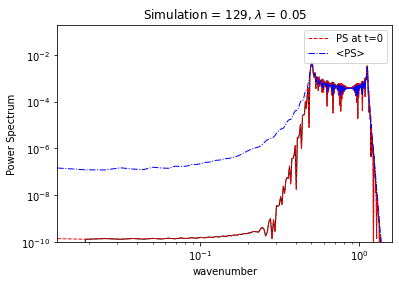

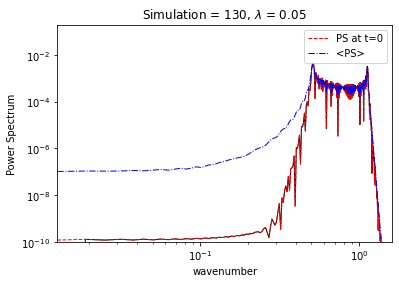

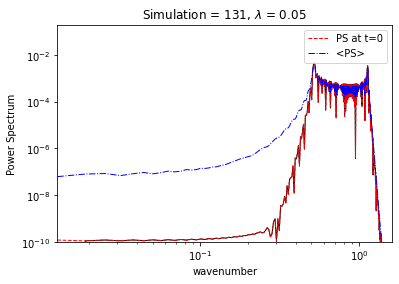

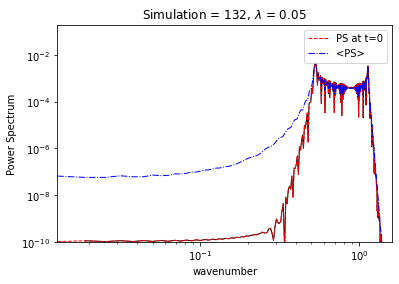

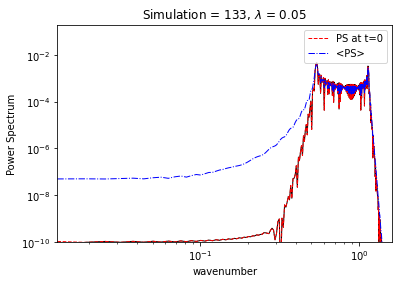

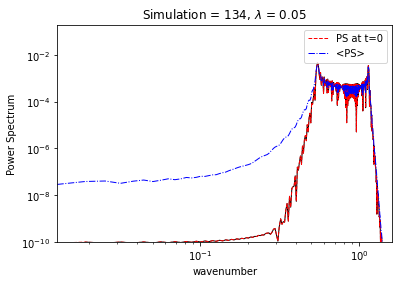

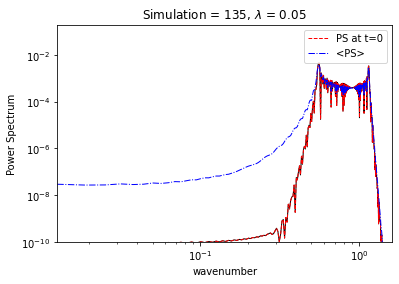

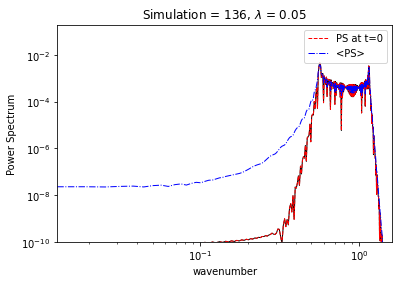

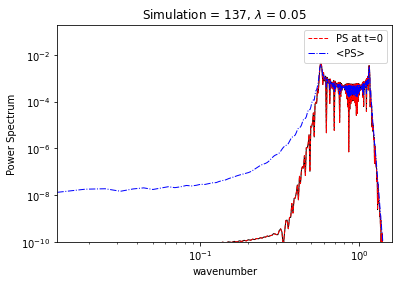

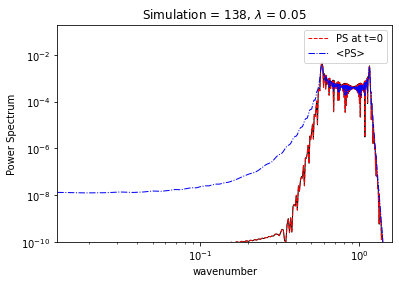

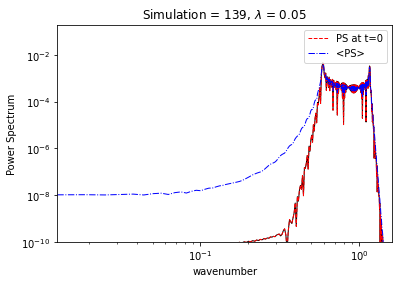

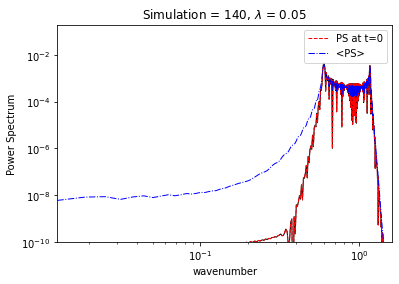

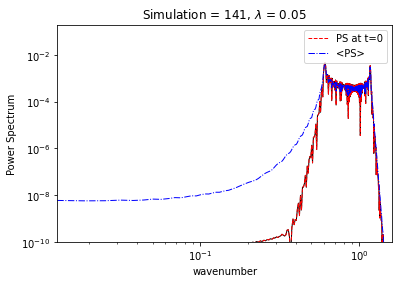

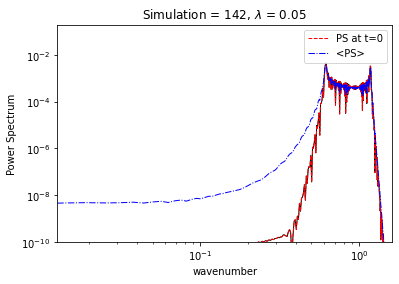

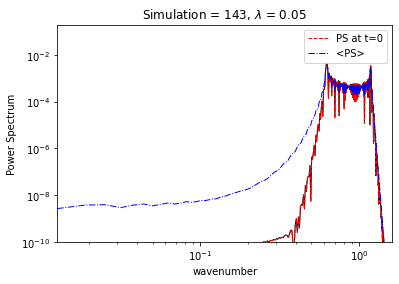

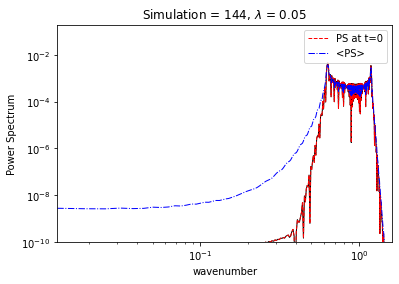

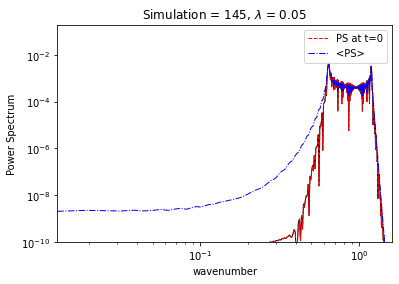

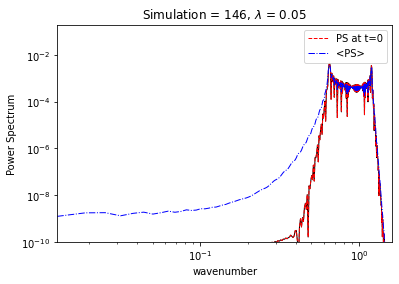

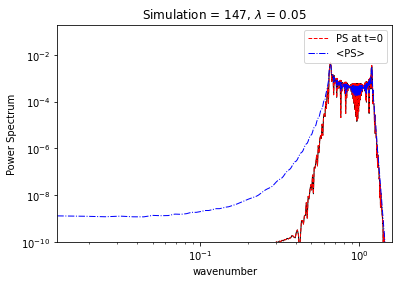

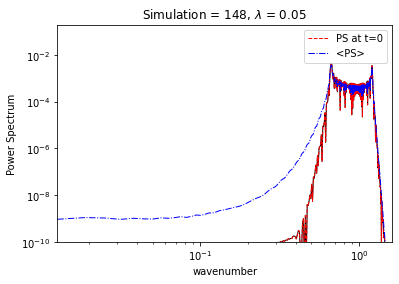

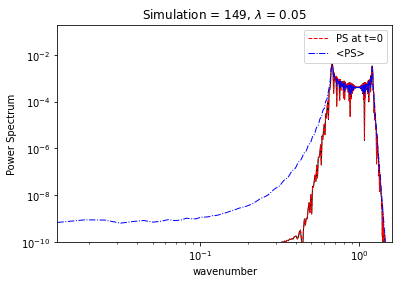

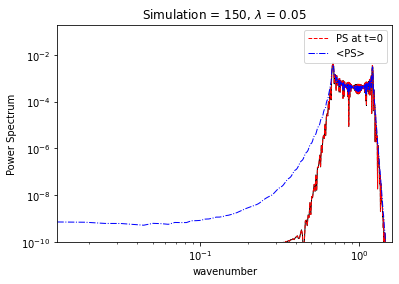

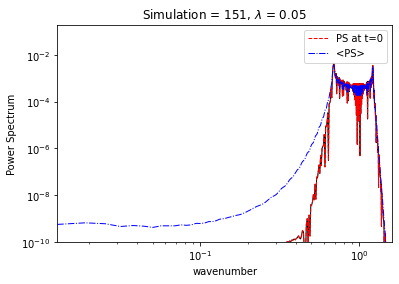

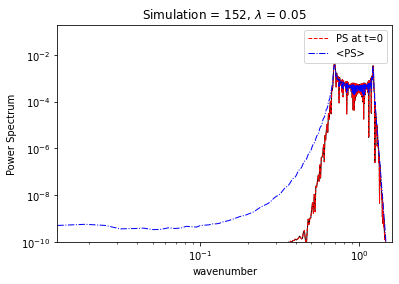

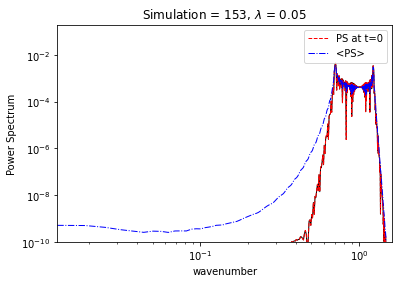

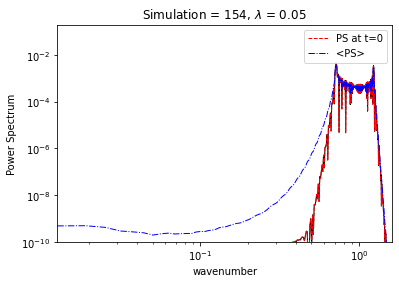

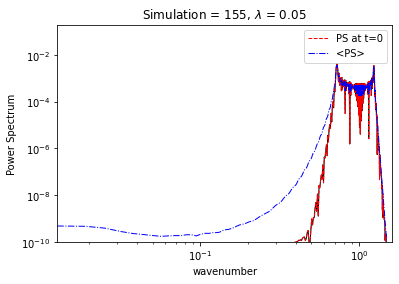

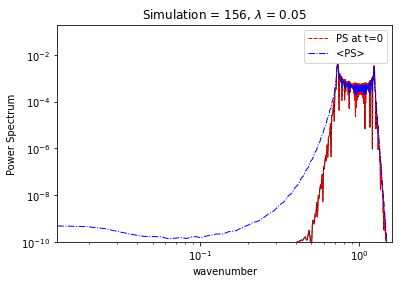

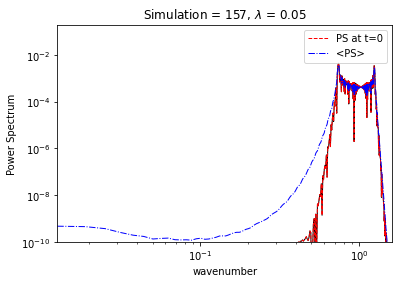

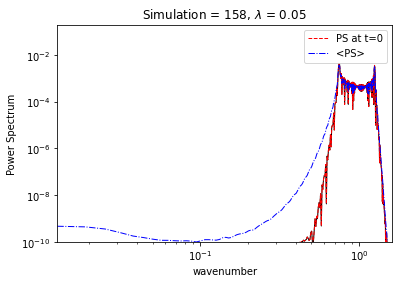

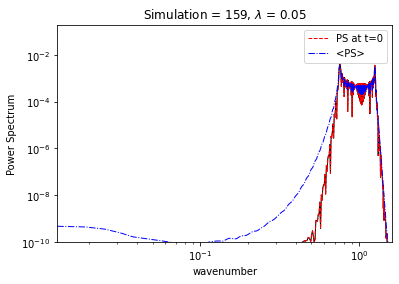

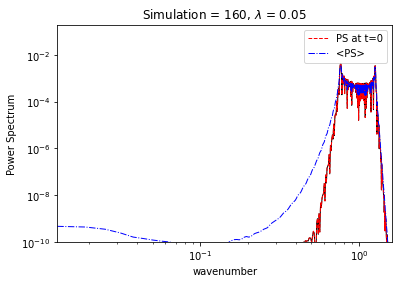

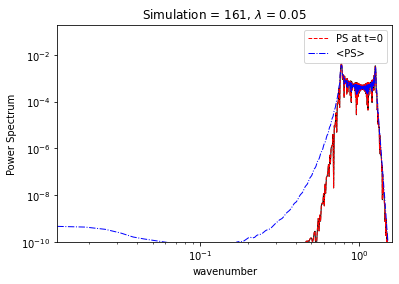

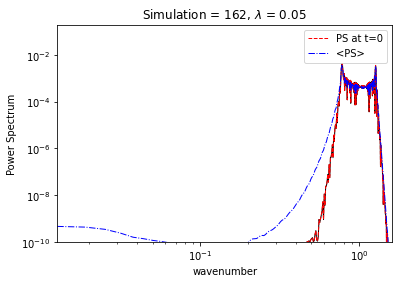

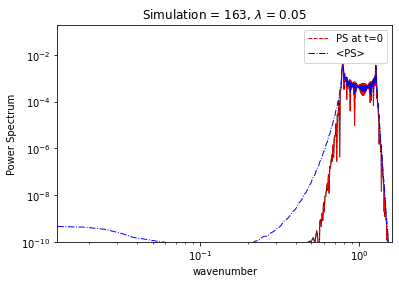

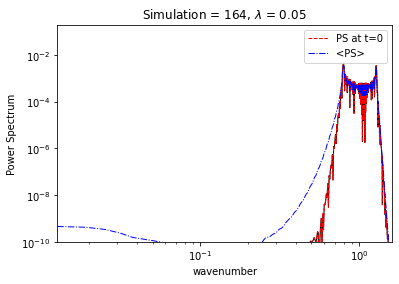

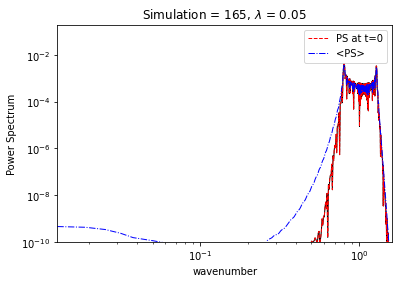

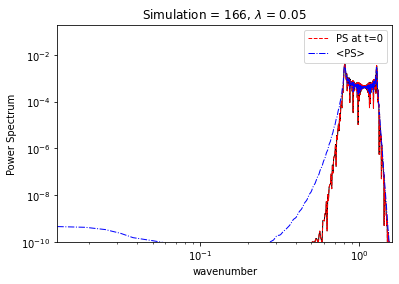

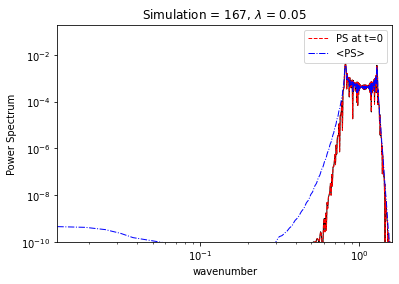

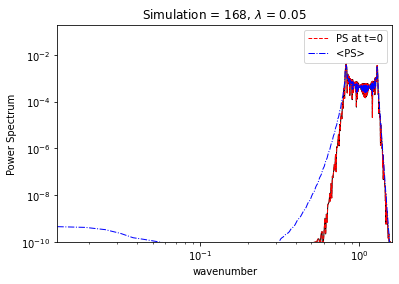

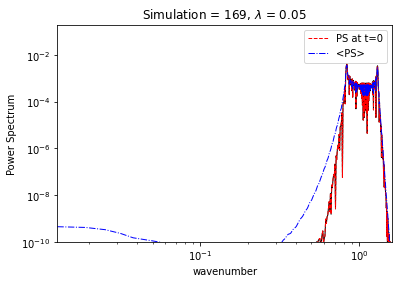

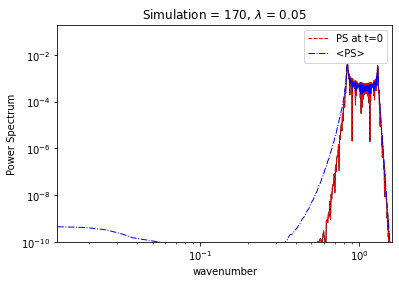

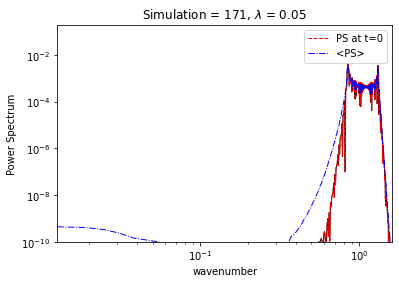

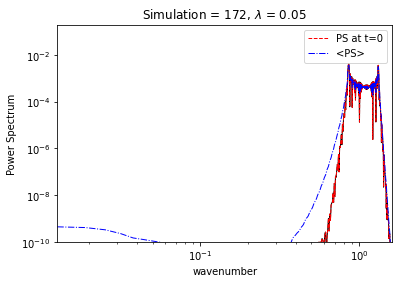

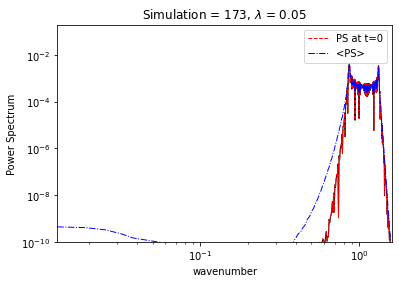

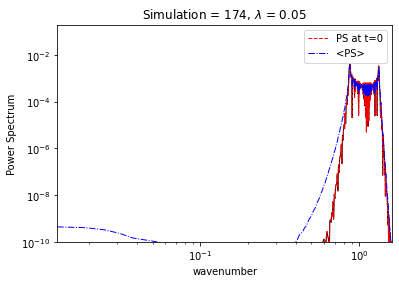

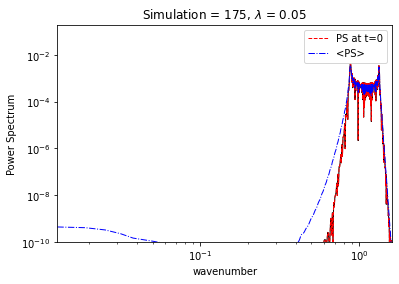

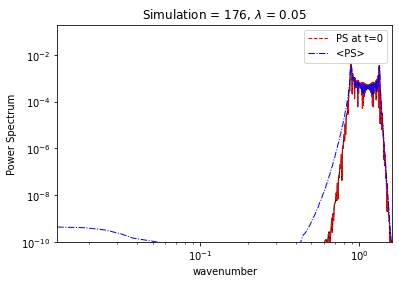

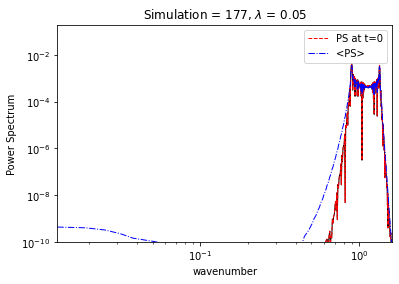

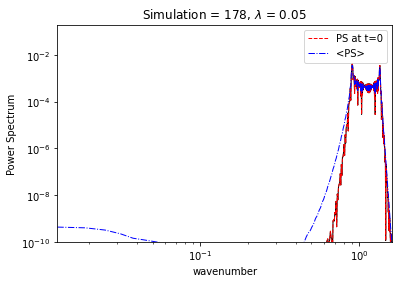

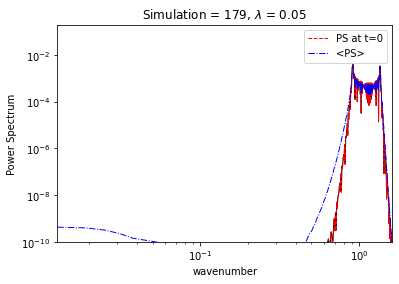

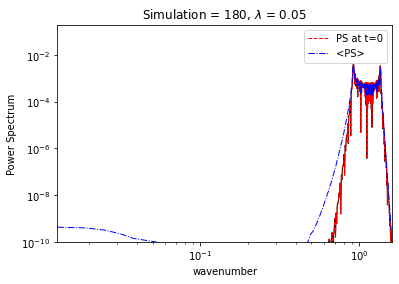

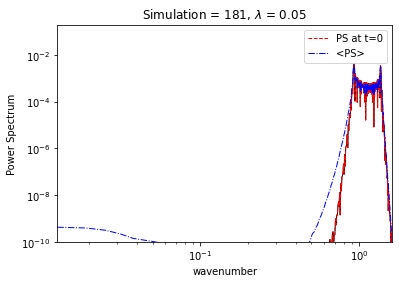

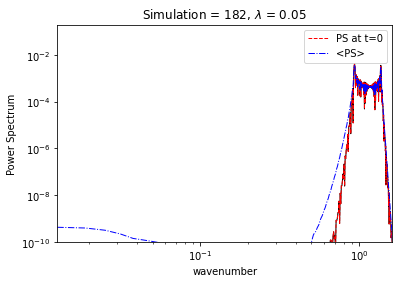

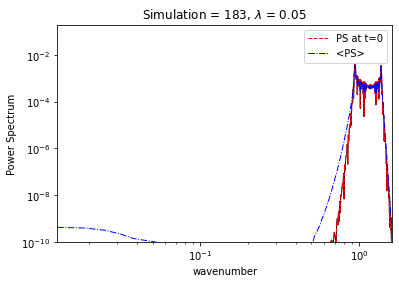

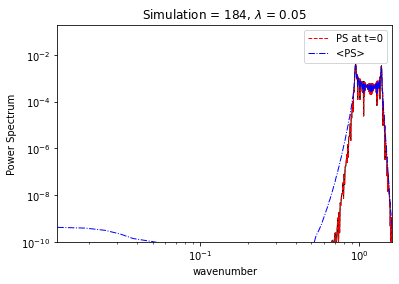

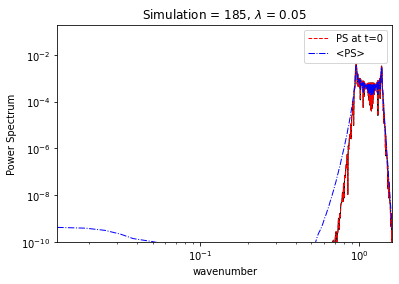

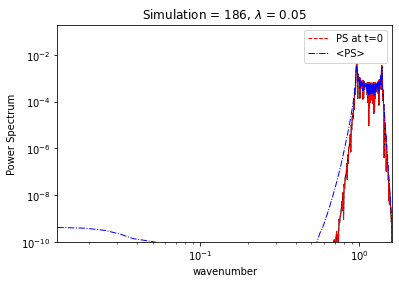

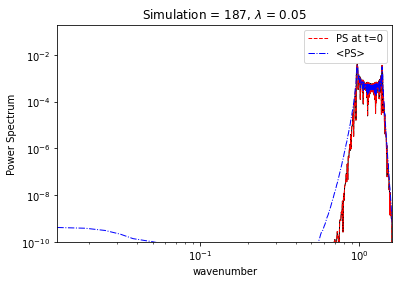

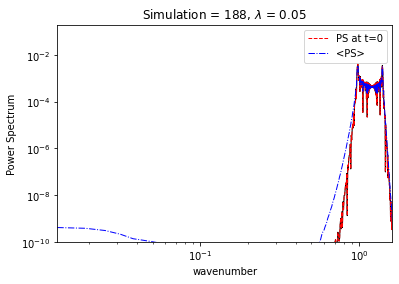

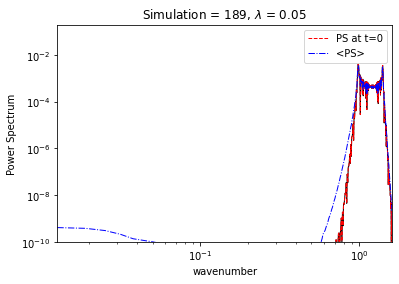

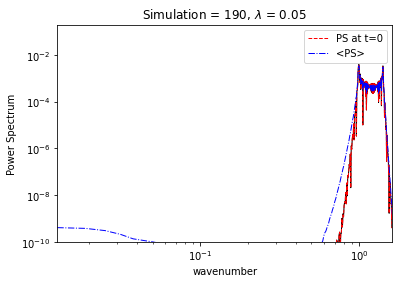

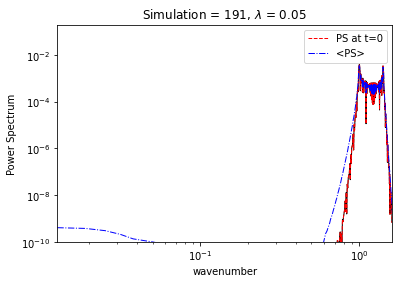

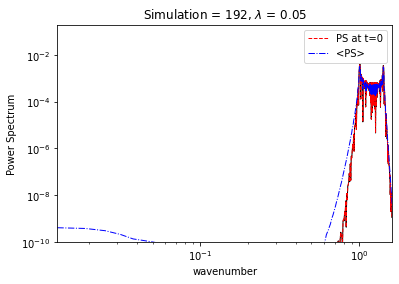

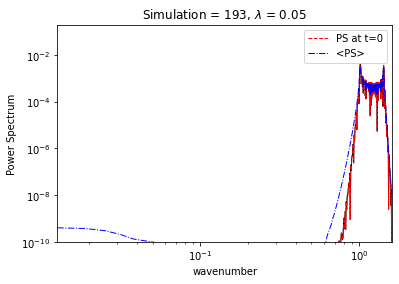

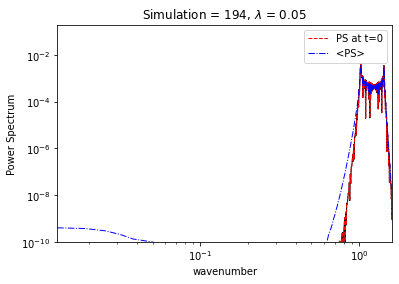

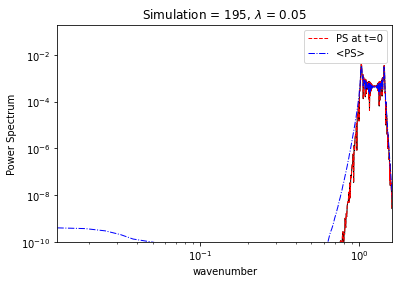

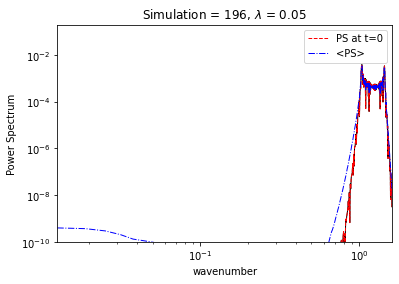

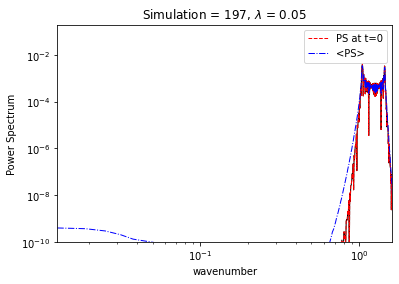

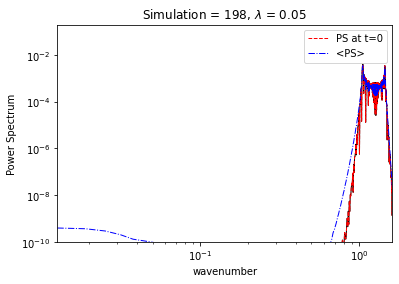

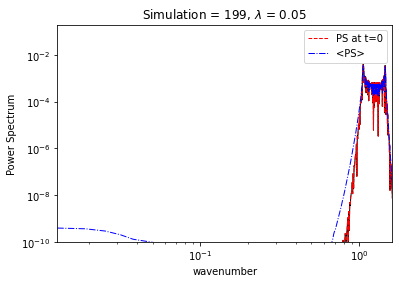

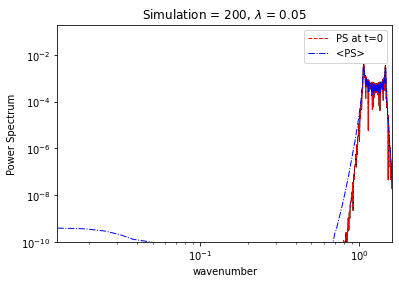

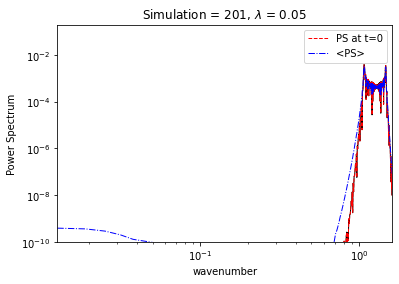

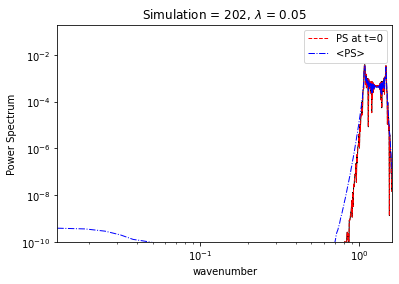

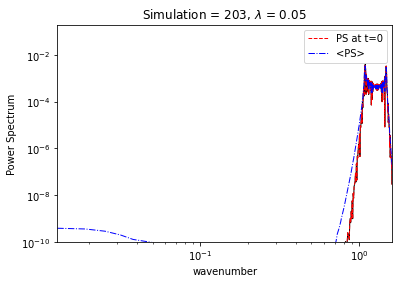

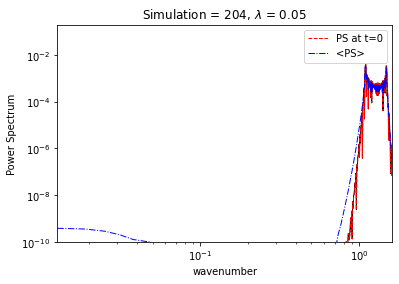

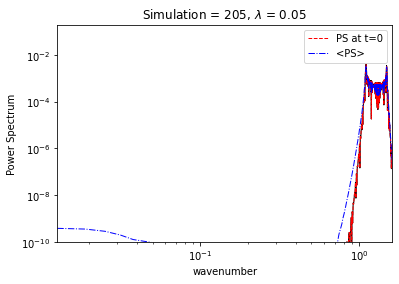

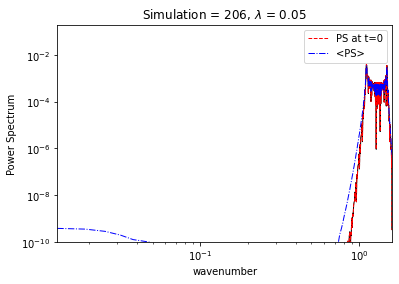

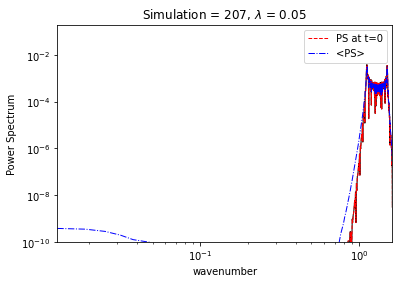

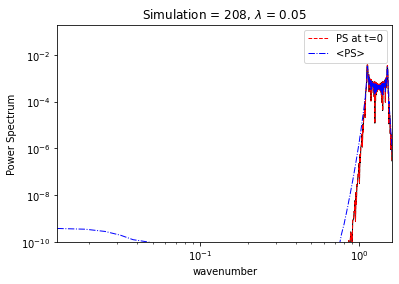

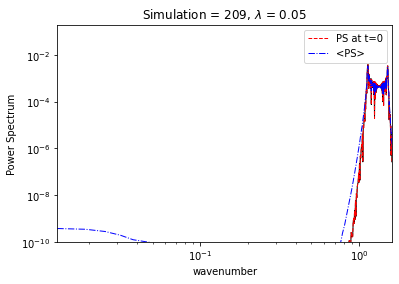

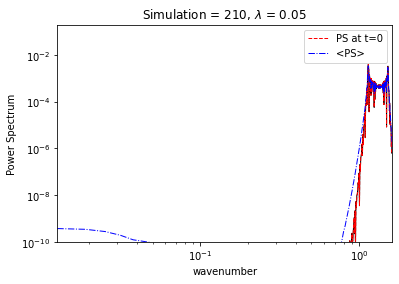

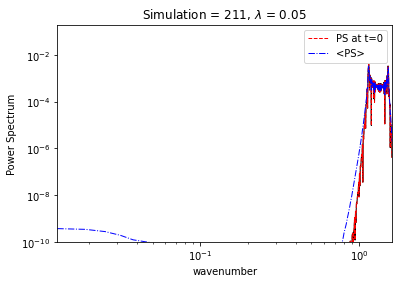

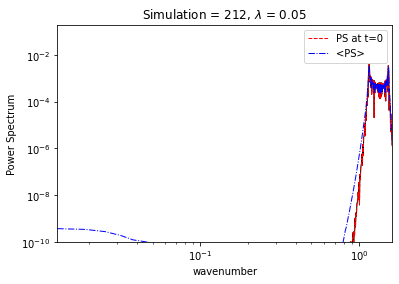

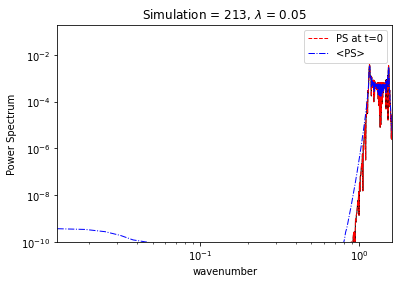

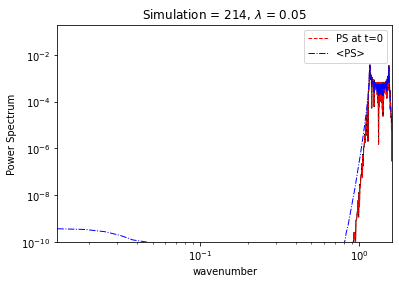

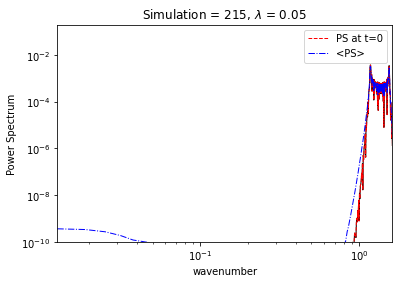

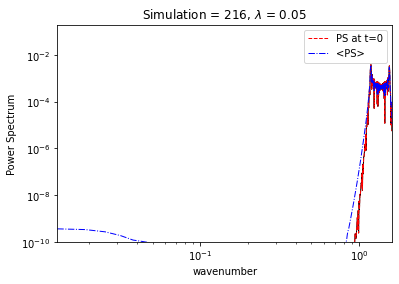

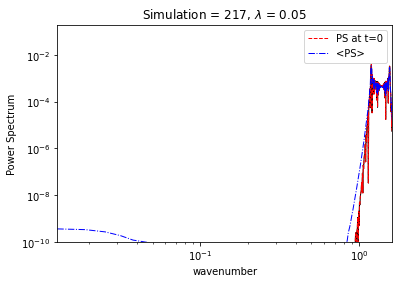

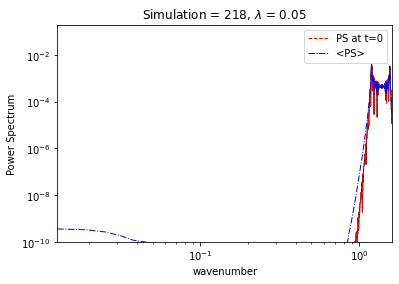

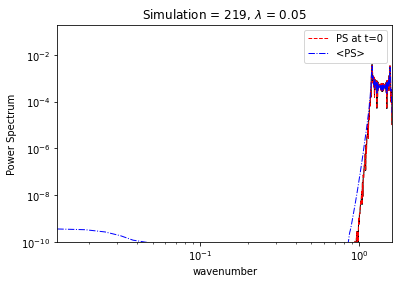

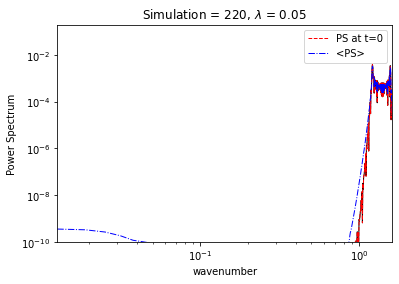

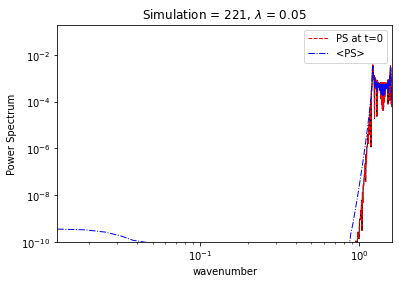

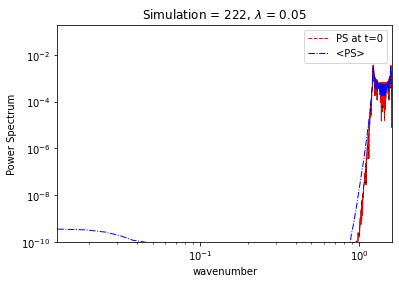

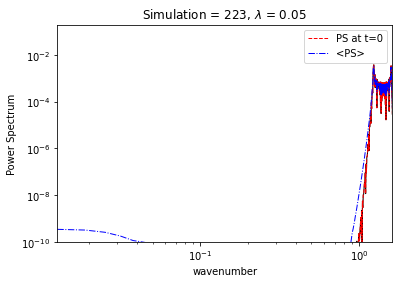

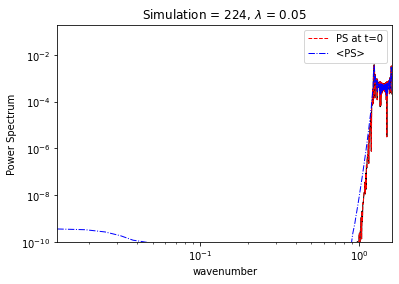

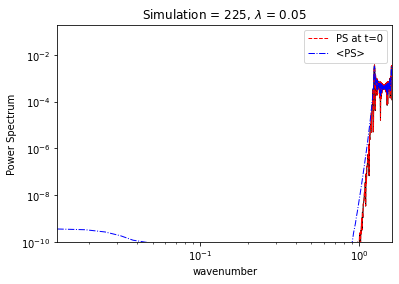

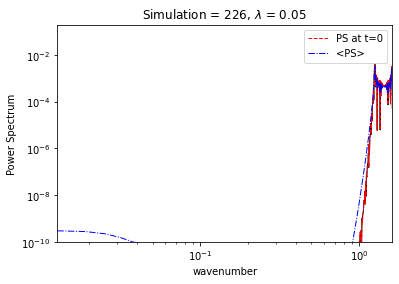

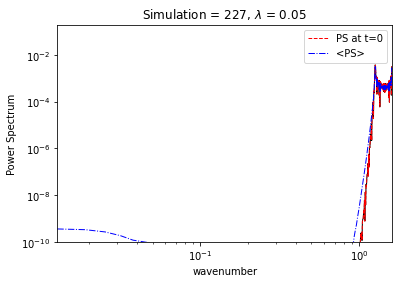

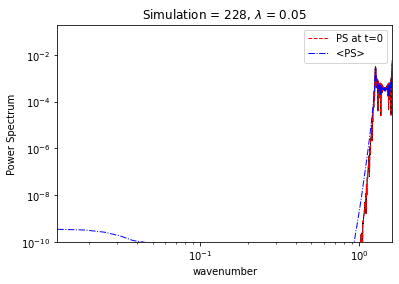

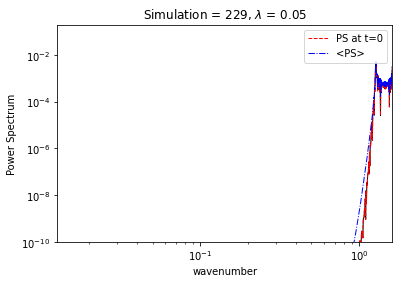

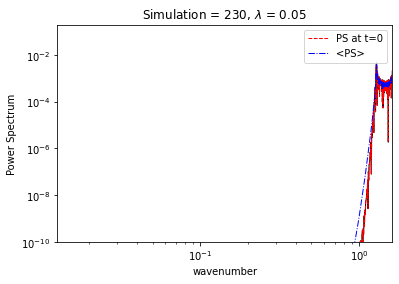

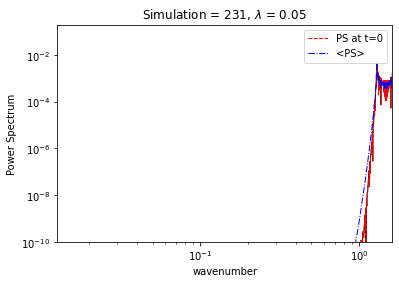

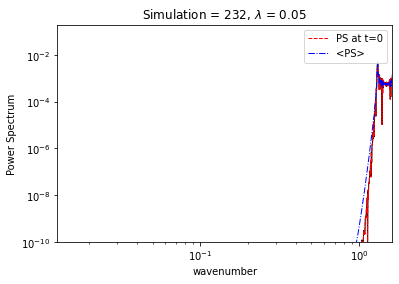

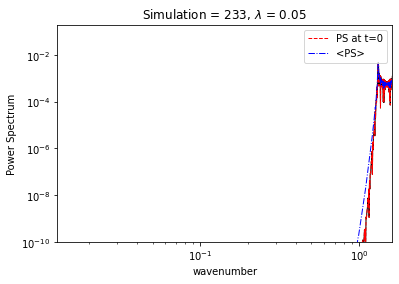

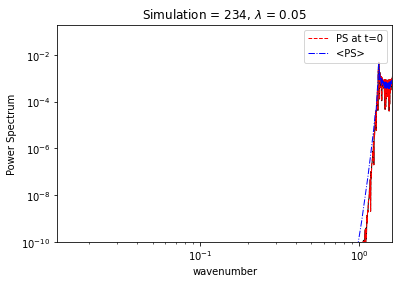

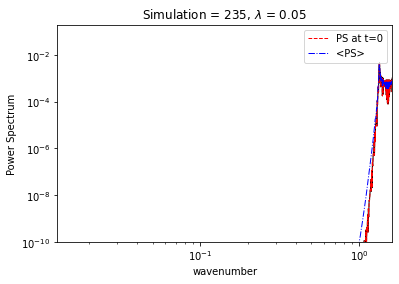

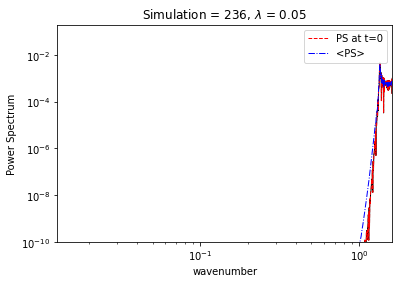

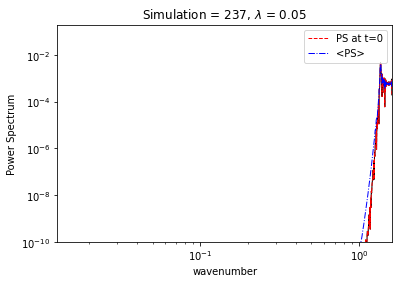

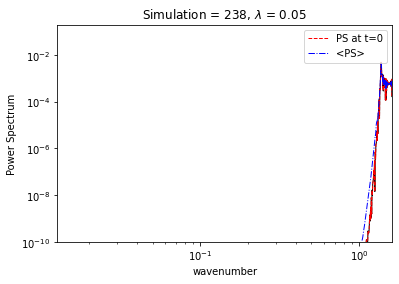

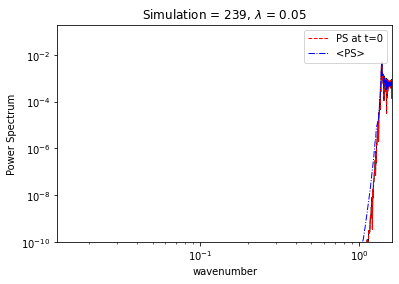

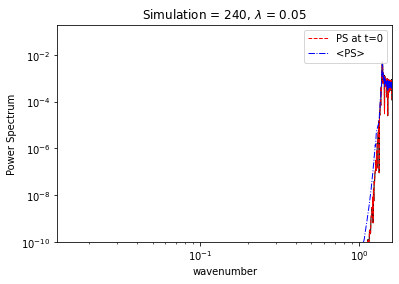

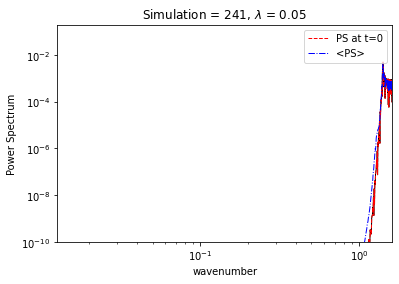

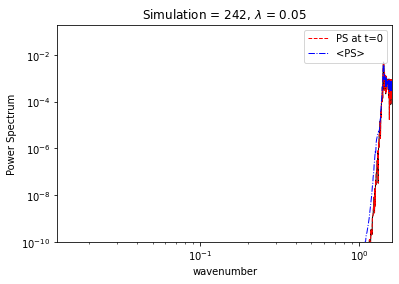

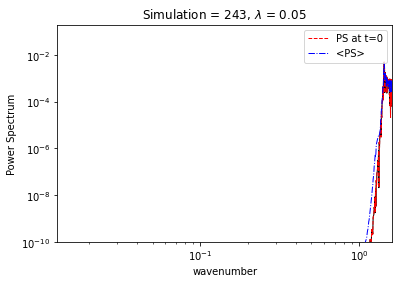

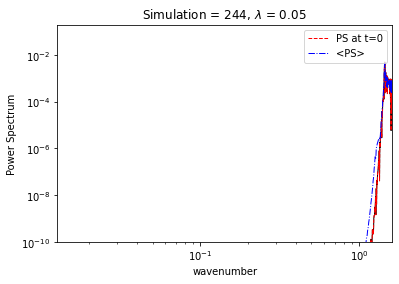

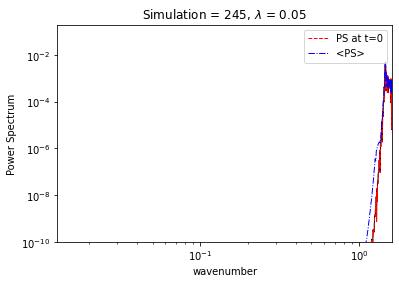

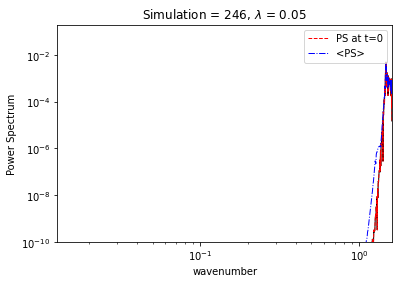

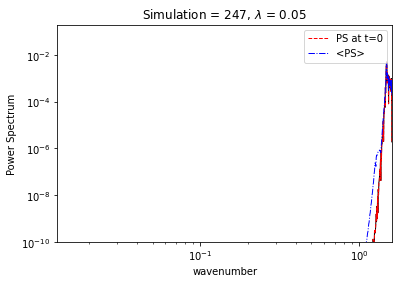

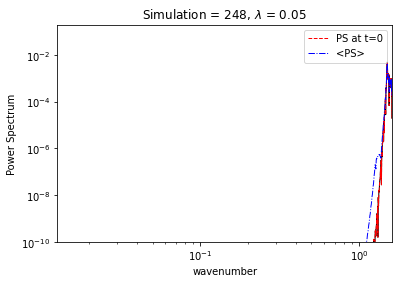

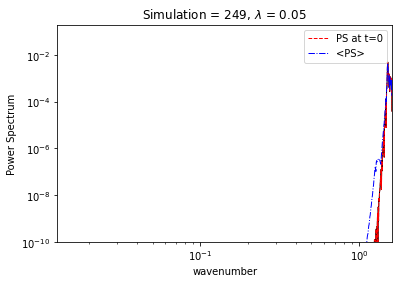

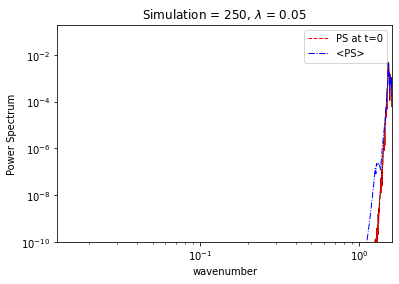

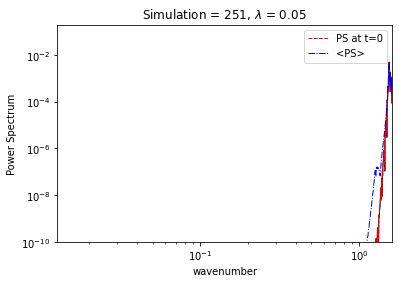

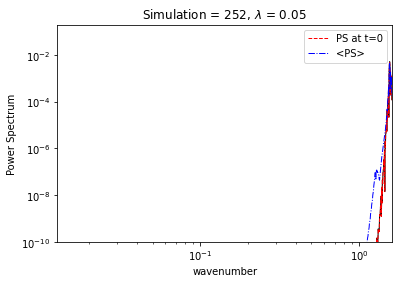

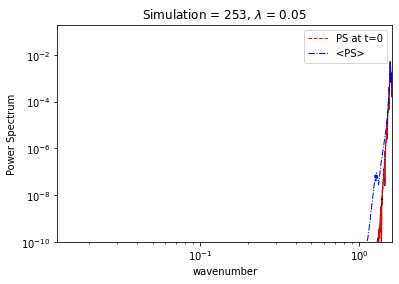

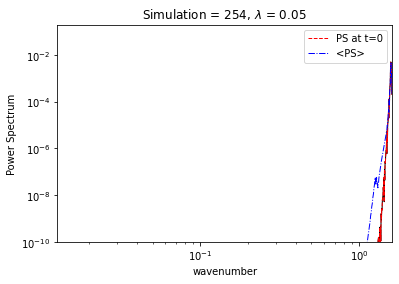

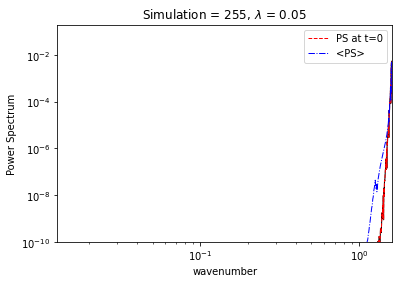

In [18]:
for sim in range(0, nSims):
    fig, ax = plt.subplots(1, 1, figsize = (6,4))
    colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))

    unit_vec = np.asarray([0. if x!=sim else norm/w2bare[sim]**0.25 for x in range(knyq)])
    projection = np.dot(np.transpose(transfMatrix),unit_vec)
    projection[0] = 0.
    plt.plot((klist+knyq)*dk, np.abs(projection), linewidth=1, color='k')

    dataPS0 = np.abs(np.fft.ifft(all_data[sim,0,0]))
    plt.plot((klist+knyq)*dk, dataPS0, color='r', label='PS at t=0', alpha=1, ls='--', linewidth=1)

    dataPS = np.mean(np.abs(np.fft.ifft(all_data[sim,0], axis=1)), axis=0)
    plt.plot((klist+knyq)*dk, dataPS, color='b', label='<PS>', alpha=1, ls='-.', linewidth=1)

#    for time in range(0, nTime, 100):
#        col=next(colors)
#        dataPS = np.abs(np.fft.ifft(all_data[sim,0,time]))
#        plt.plot(klist*dk, dataPS, color=col, label='t = '+str(time), alpha=1, ls=':')

    plt.legend(loc='upper right')
    plt.title(r'Simulation = '+str(sim)+r', $\lambda$ = '+str(lamb))
    plt.axhline(0, ls='--', color='darkgray')
    plt.xlim((klist+knyq)[0]*dk, (klist+knyq)[255]*dk)
    plt.ylim(1e-10,0.2)
    plt.xlabel(r'wavenumber')
    plt.ylabel(r'Power Spectrum')
    plt.yscale('log')
    plt.xscale('log')
    plt.show()